### Imports

In [1]:
# Import all of the requried libraries
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
# import statistics
from statistics import mode,mean
from scipy import interpolate
import os
import os.path
import json
import time

# These are all of the libraries that I manually created

import IOfunctions as IO
import GUIfunctions as GUI
import Processfunctions as process

# Through 3D slicer
# start_index = 0 # starts at 195nm
# start_index = 742 # starts at 350nm
start_index = 790 # starts at 360nm
# start_index = 1070 # starts at 420nm

# print pandas version
print(pd.__version__)

2.0.0


## Data Loading and Formatting 


#### Load, Format, and Save data

In [2]:
# This function combines loading the data with 
def loadDataset(dataPath,start_index=790,end_index=-1,sep=','):
    '''
    Function: loadDataset
    ---------------------
    This function loads in the data from the dataPath, records the time each sample was taken, and returns the dataset as a numpy array.
    '''
    Dataset = []
    Time = []
    print("Loading in: ", dataPath)
    for name in os.listdir(dataPath):
        # print(name)
        df = pd.read_csv(os.path.join(dataPath,name), sep=sep,engine='python', header=None)
        # trim to 360 nm
        df = df.iloc[:, start_index:]
        # convert to an array
        data_arr = df.to_numpy()
        # Sum the columns of the array
#         spectrum_arr = np.sum(data_arr[1:, 1:],axis=0)
        spectrum_arr = np.mean(data_arr[1:, 1:],axis=0)
        # Grab the wavelength values
        wavelength_arr = data_arr[0, 1:]
        # Concatenate the vectors as columns
        data_arr = np.concatenate((wavelength_arr.reshape(-1,1), spectrum_arr.reshape(-1,1)), axis=1)
        # append to the dataset
        Dataset.append(data_arr)

        # Get the time of the sample
        ctime = os.path.getmtime(os.path.join(dataPath,name))
        Time.append(ctime)
    Dataset = np.array(Dataset,dtype='float')
    Time = np.array(Time,dtype='float')
    # print("Time shape: ", Time.shape)
    return Dataset, Time

# LOADING DATASET 
# FORMAT_DATASET = True
FORMAT_DATASET = False
dataset_name = 'KidneyData_march3'
trialPath = "C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03"
sampleNameList = [f for f in os.listdir(trialPath) if f.startswith('Patient')]

# define a pandas df to store the incoming data
class0_name = 'Normal'
class1_name = 'Cancer'

if FORMAT_DATASET:
    Formatted_dataset_df = pd.DataFrame(columns=['PatientID', 'SampleID', 'Label (numeric)', 'Label', 'Data', 'Time'])  
    for sampleName in sampleNameList:
        patientID = sampleName.split('_')[0]
        sampleID = sampleName.split('_')[1] + '_' +sampleName.split('_')[2]
        # define the class names for folders which start with cancer or normal
        classNameList = [f for f in os.listdir(os.path.join(trialPath,sampleName)) if f.startswith('Cancer') or f.startswith('Normal')]
        # Remove names containing AmbientLight
        classNameList = [f for f in classNameList if not f.endswith('AmbientLight')]
        # for each folder sampleName folder, check if the class folders exist
        for className in classNameList:
            # if className contains cancer, then label = 1
            if class0_name in className:
                label = 0
            else:
                label = 1
            # Check to see if the path exists
            dataPath = os.path.join(trialPath,sampleName,className)
            if os.path.exists(dataPath):
                data, time = loadDataset(dataPath,start_index=start_index, sep=',')
                # for each data file, append to the dataset
                for i in range(data.shape[0]):
                    new_row = {'PatientID':patientID, 
                            'SampleID':sampleID, 
                            'Label (numeric)':label, 
                            'Label':className, 
                            'Data':data[i,:,:],
                            'Time': time[i]
                    }
                    # Dataset_df = Dataset_df.append(new_row, ignore_index=True)
                    Formatted_dataset_df = pd.concat([Formatted_dataset_df, pd.DataFrame([new_row])], ignore_index=True)
    # For each Data, convert the array to a string and save it to a csv file
    Formatted_dataset_df['Data'] = Formatted_dataset_df['Data'].apply(lambda x: json.dumps(x.tolist()))
    file_name = os.path.join(trialPath, dataset_name + '_Formatted_Dataset.csv')
    Formatted_dataset_df.to_csv(file_name, index=False)

### Load from file

In [3]:
file_name = os.path.join(trialPath, dataset_name + '_Formatted_Dataset.csv')
# Load in the dataset
Dataset_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
Dataset_df['Data'] = Dataset_df['Data'].apply(lambda x: np.array(json.loads(x)))
Dataset_df.shape
Dataset_df.head()

,PatientID,SampleID,Label (numeric),Label,Data,Time
0,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0055262738350994245], ...",1.677865e+09
1,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0021762760675127974], ...",1.677866e+09
2,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.004287867652463011], [...",1.677866e+09
3,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.003312623581628423], [...",1.677866e+09
4,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.008101678916785034], [...",1.677866e+09


In [4]:
# get the time of the sample
sample_time = Dataset_df.iloc[0,5]
print(float(sample_time))
# convert the creation time to a readable format
sample_time_str = time.strftime('%H:%M:%S', time.localtime(sample_time))
print(f'The sample was taken at {sample_time_str}')

1677865018.0
The sample was taken at 12:36:58


## Visualization Trials

### Split data

In [5]:
# Now that I have everything compiled into a dataframe, I can now split the data

# Split the whole dataste into data into two classes
allNormal_df = Dataset_df[Dataset_df['Label (numeric)'] == 0]
allCancer_df = Dataset_df[Dataset_df['Label (numeric)'] == 1]

# Get just data which sampleID contains 1_front
sample1Normal_df = allNormal_df[allNormal_df['SampleID'].str.contains('1')]
sample1Cancer_df = allCancer_df[allCancer_df['SampleID'].str.contains('1')]

data_0_df = allNormal_df
#print the shape of the data
print(data_0_df.shape)
data_1_df = allCancer_df
#print the shape of the data
print(data_1_df.shape)

# Extract the data from the dataframe
data_0 = np.array(data_0_df['Data'].tolist())
labels0 = np.array(data_0_df['Label (numeric)'].tolist())
data_1 = np.array(data_1_df['Data'].tolist())
labels1 = np.array(data_1_df['Label (numeric)'].tolist())

# labels1 = data_1_df['Label']



(84, 6)
(315, 6)


In [6]:
print('Normal data shape: ',data_0.shape)
print('Cancer data shape: ',data_1.shape)
# print the labels shape
print('Normal labels: ',labels0.shape)
print('Cancer labels: ',labels1.shape)


Normal data shape:  (84, 2858, 2)
Cancer data shape:  (315, 2858, 2)
Normal labels:  (84,)
Cancer labels:  (315,)


#### Load in the broadband transfer function

In [7]:
def loadSpectrum(path, col_name=None,start_index=774,end_index=-1,sep=';'):
#     df = pd.read_csv(path + name,sep=';',engine='python')
    df = pd.read_csv(path,sep=sep,engine='python')
#     print(df)
    if not(col_name == None):
        df[col_name] = df.index
    data = df[start_index:end_index]
#     print(data)
    data_arr = data.to_numpy()
    data_arr = np.array(data_arr,dtype='float')
    return data_arr

# LOAD IN BASELINES

dataPath = os.getcwd()
folderName = 'March2022_raw_data'
file_name = 'SLS201L_Spectrum_reformatted.csv'
dataPath_BrOut = os.path.join(dataPath,"data",folderName,file_name)
print(dataPath_BrOut)
baseline_BrOut_raw = loadSpectrum(dataPath_BrOut, 'Wavelength', start_index=10, end_index=675, sep=',')
# Interpolate such that the downloaded spectrum has the same values of the data
x = baseline_BrOut_raw[:,0]
y = baseline_BrOut_raw[:,1]
f = interpolate.interp1d(x,y)
xnew = data_0[0,:,0]
ynew = f(xnew)
baseline_BrOut = np.transpose(np.array([xnew,ynew]))
print(baseline_BrOut.shape)
print('Data shape', data_0.shape)

c:\GithubProjects\Spectroscopy_TrackedTissueSensing\data\March2022_raw_data\SLS201L_Spectrum_reformatted.csv
(2858, 2)
Data shape (84, 2858, 2)


In [8]:
# plt.plot(data_0[0,:,0],data_0[0,:,1])
# plt.plot(data_1[0,:,0],data_1[0,:,1])
# data_0.shape
# print(data_0[0,0,0])

### Display the raw data

In [9]:
# Displaying all of the spectra to visually inspect results

# This should be in GUI with all the inputs as parameters
wavelength_start = data_0[0,0,0]
wavelength_end = data_0[0,-1,0]

w = np.linspace(wavelength_start,wavelength_end,len(data_0[1]))
# # # Display an example of data_0
# GUI.plotSpectra(xdata=data_0[0,:,0],ydata=data_0[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Unprocessed data_0 Spectrum')
# # Display an example of data_1
# GUI.plotSpectra(xdata=data_1[0,:,0], ydata=data_1[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Unprocessed data_1 Spectrum' )
# Display an example of broadband output
# GUI.plotSpectra(xdata=baseline_BrOut[:,0],ydata=baseline_BrOut[:,1],xlab="Wavelength[nm]", ylab='Incident Intensity',title='baseline_BrOut')

# Plot the baseline_BrOut using plotly
import plotly.graph_objects as go
wavelengths = baseline_BrOut[:,0]
intensities = baseline_BrOut[:,1]

fig = go.Figure()
fig.add_trace(go.Scatter(x=wavelengths, y=intensities, mode='lines', line=dict(color='blue')))
# Customize the plot layout
fig.update_layout(xaxis_title='Wavelength (nm)',
                  yaxis_title='Normalize Intensity',
                  showlegend=False,
                  plot_bgcolor='white',
                  font=dict(size=16),
                  width=800,  # Set the width of the figure in pixels
                  height=600  # Set the height of the figure in pixels
                  )
fig.update_xaxes(
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.update_yaxes(
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
# Show the plot
fig.show()

In [10]:
# Function to plot all the spectra
def plotAll(data,title='', xtitle='', ytitle=''):
    plt.figure()
    for i in range(len(data)):
        plt.plot(data[i,:,0],data[i,:,1])
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)


def plotWColourMap(data, title, xlabel, ylabel, step=1):
    """
    Plot all samples of class1 on a single figure using a colour map to denote chronological order.

    Args:
    - data (ndarray): a 3D array of shape (num_samples, num_wavelengths, 2) containing the spectral data
    - title (str): the title of the plot
    - xlabel (str): the label of the x-axis
    - ylabel (str): the label of the y-axis

    Returns:
    - None
    """

    # create the colour map
    cmap = plt.get_cmap('viridis')

    # plot the data with the colour map
    plt.figure()
    for i in range(len(data)-1):
        # plot every third spectra
        if i%step == 0:
            plt.scatter(data[i,:,0], data[i,:,1], s=0.1, c=cmap(i/len(data)))

    # add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


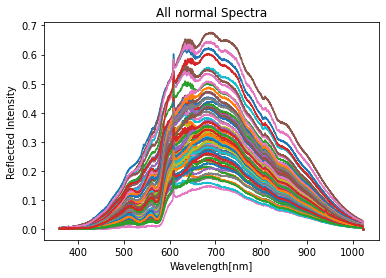

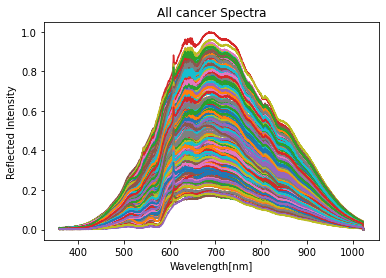

In [11]:
# Plot all samples of class0 on a single figure without using plotSpectra
plotAll(data_0,'All normal Spectra','Wavelength[nm]','Reflected Intensity')

# Plot all samples of class1 on a single figure without using plotSpectra
plotAll(data_1,'All cancer Spectra','Wavelength[nm]','Reflected Intensity')

# GUI.plotSpectra(xdata=data_1[0,:,0], ydata=data_1[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Unprocessed data_1 Spectrum' )


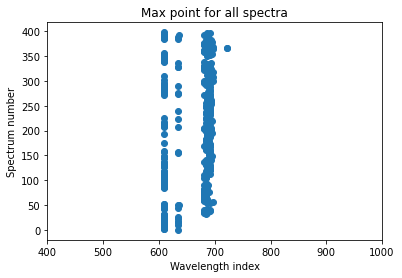

In [12]:
# PLOT the location of the max point for each spectrum
def plotMax(data, title, xlabel, ylabel):
    """
    Plot the location of the max point for each spectrum.

    Args:
    - data (ndarray): a 3D array of shape (num_samples, num_wavelengths, 2) containing the spectral data
    - title (str): the title of the plot
    - xlabel (str): the label of the x-axis
    - ylabel (str): the label of the y-axis

    Returns:
    - None
    """

    # find the max point for each spectrum
    max_points_indices = np.argmax(data[:,:,1], axis=1)
    # Find the corresponding wavelength
    max_points = data[:,max_points_indices,0]
    # plot the max points
    SampleNumber = range(len(data))
    plt.figure()
    plt.scatter(max_points[0],range(len(data)))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # change the range of the x-axis
    plt.xlim(400, 1000)

# concatinate the data_0 and data_1
d = np.concatenate((data_0, data_1), axis=0)
# Plot the location of the max point for each spectrum of class0
plotMax(d, 'Max point for all spectra', 'Wavelength index', 'Spectrum number')


In [13]:
# data_0_save = data_0.copy()
# data_1_save = data_1.copy()

# data_0 = data_0_save.copy()
# data_1 = data_1_save.copy()


### Ambient light removal


In [14]:
# Step 1: Load in the ambient light and the raw signal
def formatAmbientLight(dataPath,start_index=790,end_index=-1,sep=','):
    '''
    Function: loadDataset
    ---------------------
    This function loads in the measured ambient light from a given dataPath, it 
    The dataPath leads to a folder. Open the folders containing _AmbientLight in the name. Load and format the data contained.
    '''
    Signal = []
    AmbientLight = []
    # print("Loading in: ", dataPath)
    for name in os.listdir(dataPath):
        # print(name)
        df = pd.read_csv(os.path.join(dataPath,name), sep=sep,engine='python', header=None)
        df = df.iloc[:, start_index:]
        data_arr = df.to_numpy()
        spectrum_arr = np.mean(data_arr[1:, 1:],axis=0)
        wavelength_arr = data_arr[0, 1:]
        data_arr = np.concatenate((wavelength_arr.reshape(-1,1), spectrum_arr.reshape(-1,1)), axis=1)
        if name.endswith('_AmbientLight.csv'):
            AmbientLight.append(data_arr)
        else:
            Signal.append(data_arr)
    Signal = np.array(Signal,dtype='float')
    AmbientLight = np.array(AmbientLight,dtype='float')
    # Average the singal and ambient light
    Signal = np.mean(Signal,axis=0)
    AmbientLight = np.mean(AmbientLight,axis=0)
    return Signal, AmbientLight

# Step 2: Calculate the ratio of the signal to the ambient light
def calcAmbientRatio(signal):
    # Find the peak ambient light value in the range of 1110 to 1130
    ambient_peak_value = np.max(signal[1110:1130,1])
    # Find the peak signal value in the range of 1200 to 1800
    signal_peak_value = np.max(signal[1200:1800,1])
    # calculate the ratio of the signal to the ambient light
    ratio = signal_peak_value/ambient_peak_value
    return ratio

# Step 3: Use the baseline ratio and the measured ambient light signal to eliminate the ambient light from the remaining signals
def removeAmbientLight1(data,ambient_baseline,ratio_baseline):
    # For each signal in dataset, calulate the ratio of the signal to the ambient light
    ratio_data = calcAmbientRatio(data)
    # print("ratio_data",ratio_data)
    # compare to the baseline ratio
    ratio_comparison = (ratio_baseline/ratio_data)
    # scale the ambient light by the comparison ratio
    scaled_ambient = ambient_baseline.copy()
    scaled_ambient[:,1] = scaled_ambient[:,1]/ratio_comparison
    # subtract the scaled ambient light from the signal
    data[:,1] = data[:,1] - scaled_ambient[:,1]
    return data


In [15]:
'''
# Calculate the baseline ambient light ratio for each sample 
Amoon says this technique is too specific and that I need to do this removal in a more general way
Average the ambient light over 
'''
dataPath = "C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03"
# print("Loading in: ", dataPath)
# find all of the sample folders
sampleNameList = [f for f in os.listdir(dataPath) if f.startswith('Patient')]
# print("List of samples", sampleNameList)
baseline_ratios = []
baseline_ambient = []
trialName = []
for sampleName in sampleNameList:
    # append the sample name to the dataPath
    samplePath = os.path.join(dataPath,sampleName)
    # print("Loading in: ", samplePath)
    # find all of the folders that end in _AmbientLight
    ambientLightNameList = [f for f in os.listdir(samplePath) if f.endswith('AmbientLight')]
    # print(ambientLightNameList) 
    for name in ambientLightNameList:
        path = os.path.join(samplePath,name)
        print("Loading in: ", sampleName + ' ' + name)
        # Step 1: Load in the ambient light and the raw signal
        # path = "C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03/PatientA_Sample3_front/Cancer_AmbientLight"
        signal, ambientLight = formatAmbientLight(path)

        # Step 2: Calculate the ratio of the signal to the ambient light
        ratio_baseline = calcAmbientRatio(signal)
        print("baseline ratio",ratio_baseline)

        # Step 3: Use the baseline ratio and the measured ambient light signal to eliminate the ambient light from the remaining signals
        ambient_baseline = ambientLight.copy()
        ratio_baseline
        baseline_ratios.append(ratio_baseline)
        baseline_ambient.append(ambient_baseline)

        # The information I need is the sampleID and the class
        sampleID = sampleName.split('_')[1] + '_' +sampleName.split('_')[2]
        # extract cancer or normal from the name
        className = name.split('_')[0]
        # if string className contains cancer, then label = 1
        print(className)
        if className == 'Cancer':
            label = 1
        else:
            label = 0
        
        trialName.append(str(label) + '-' + sampleID)
        # break
    # break
print(baseline_ratios)
print(trialName)

Loading in:  PatientA_Sample1_back Cancer_AmbientLight
baseline ratio 0.9806104107367535
Cancer
Loading in:  PatientA_Sample1_back Normal_AmbientLight
baseline ratio 1.0408302431377414
Normal
Loading in:  PatientA_Sample1_front Cancer_AmbientLight
baseline ratio 1.0857596775410496
Cancer
Loading in:  PatientA_Sample1_front Normal_AmbientLight
baseline ratio 0.9782709999600477
Normal
Loading in:  PatientA_Sample2_back Cancer_AmbientLight
baseline ratio 1.0717218189184303
Cancer
Loading in:  PatientA_Sample2_front Cancer_AmbientLight
baseline ratio 1.0639475746666587
Cancer
Loading in:  PatientA_Sample3_back Cancer_AmbientLight
baseline ratio 1.0459337392673116
Cancer
Loading in:  PatientA_Sample3_back Normal_front_AmbientLight
baseline ratio 1.1555601932799715
Normal
Loading in:  PatientA_Sample3_front Cancer_AmbientLight
baseline ratio 1.058790720428616
Cancer
Loading in:  PatientA_Sample3_front Normal_AmbientLight
baseline ratio 1.1555601932799715
Normal
[0.9806104107367535, 1.0408302

In [16]:
# I now have the baseline ratios and the baseline ambient light for each sample
# I can now use this to remove the ambient light from the data
# Create a dataframe to store the baseline ratios and the baseline ambient light
baseline_df = pd.DataFrame(columns=['SampleID', 'Label (numeric)', 'Baseline Ambient Light', 'Baseline Ratio'])
for i in range(len(baseline_ratios)):
    # Split the trial name into the class and the sampleID
    # print(trialName[i])
    sampleID = trialName[i].split('-')[1]
    # print(sampleID)
    className = trialName[i].split('-')[0]
    # print(className)
    new_row = {'SampleID':sampleID,
               'Label (numeric)':className,
               'Baseline Ambient Light':baseline_ambient[i],
               'Baseline Ratio':baseline_ratios[i]
    }
    baseline_df = pd.concat([baseline_df, pd.DataFrame([new_row])], ignore_index=True)

baseline_df['Baseline Ambient Light'] = baseline_df['Baseline Ambient Light'].apply(lambda x: json.dumps(x.tolist()))
file_name = os.path.join(trialPath, 'ambient_baseline_and_ratios.csv')
baseline_df.to_csv(file_name, index=False)
file_name = os.path.join(trialPath, 'ambient_baseline_and_ratios.csv')

baseline_df = 0
# Load in the ambient light baselines
baseline_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
baseline_df['Baseline Ambient Light'] = baseline_df['Baseline Ambient Light'].apply(lambda x: np.array(json.loads(x)))



# Loop through the dataset and remove the ambient light
baseline_df
Dataset_df
# For each sample ID and label in the baseline_df
# find unique sampleIDs
# sampleIDs = baseline_df['sampleID'].unique()
# print(sampleIDs)
# for sampleID in sampleIDs:
#     # print(sampleID)
#     labels = baseline_df['Label'].unique()
#     print(labels)

# Attempt 2
# Loop through the dataset and remove the ambient light
# Given a data, find the corresponding baseline ambient light and the baseline ratio
# for each sample in the dataset
def removeAmbientLight_method2(Dataset_df, baseline_df):
    Dataset = []
    for i in range(Dataset_df.shape[0]):
        # Get the data
        data = np.array(Dataset_df['Data'].tolist())[i,:,:]
        # Get the sampleID
        sampleID = Dataset_df['SampleID'][i]
        # Get the label
        label = Dataset_df['Label (numeric)'][i]
        # print(label)
        # Find the corresponding baseline ambient light and the baseline ratio
        # Get the row of baseline_df where baseline_df['sampleID'] == sampleID and 
        baseline_sample_row = baseline_df.loc[(baseline_df['SampleID'] == sampleID)]
        # Get the row of baseline_df where baseline_df['Label (numeric)'] == Label (numeric)
        # print(baseline_sample_row['Label (numeric)']=='1')
        baseline_row = baseline_sample_row.loc[(baseline_sample_row['Label (numeric)'] == str(label))]
        # print(baseline_row)
        # if baseline_row is empty give an error
        if baseline_row.empty:
            print("Error: baseline_row is empty")
            break
        
        # Get the baseline ambient light
        ambient_baseline = np.array(baseline_row['Baseline Ambient Light'].tolist())[0,:,:]
        # Get the baseline ratio
        ratio_baseline = np.array(baseline_row['Baseline Ratio'].tolist())[0]

        # Remove ambient light peak
        data = removeAmbientLight1(data,ambient_baseline,ratio_baseline)

        Dataset.append(data)

        # Normalize the data
        # data = process.normalize(data)
        # Display the data
        # GUI.plotSpectra(xdata=data[:,0],ydata=data[:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity', title='Signal Spectrum after subtracting ambient light')
    # Return the dataset as an array
    Dataset = np.array(Dataset,dtype='float')
    return Dataset

# Call the function to remove the ambient light
# data = removeAmbientLight_method2(Dataset_df,baseline_df)

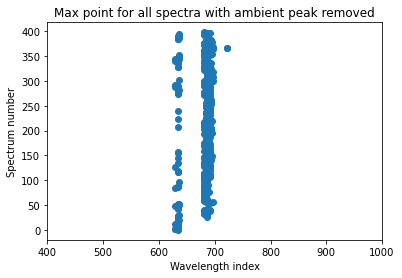

In [17]:
# temporayily remove the peak caused by ambient light
data_0_new = data_0.copy()
data_1_new = data_1.copy()
# Set the spectra to zero between 600 and 650 nm
# This is to remove the background noise using no functions
def removeAmbientLight_method1(data):
    start_index = 1110
    width = 20
    end_index = start_index + width
    for i in range(len(data)):
        data[i,start_index:end_index,1] = 0
    return data

data_0_new = removeAmbientLight_method1(data_0_new)
data_1_new = removeAmbientLight_method1(data_1_new)

# concatinate the data_0 and data_1
d = np.concatenate((data_0_new, data_1_new), axis=0)
# Plot the location of the max point for each spectrum of class0
plotMax(d, 'Max point for all spectra with ambient peak removed', 'Wavelength index', 'Spectrum number')

# Use the refleccted ambient light recorded before the experiment to estimate the ambient light from the rest of the experiment.

# Load in the ambient light

### Preprocessing of the data
* Normalize so peak is 1
* Crop to 360nm to 1024nm
* Divide by the broadband output

Text(0, 0.5, 'Reflected Intensity')

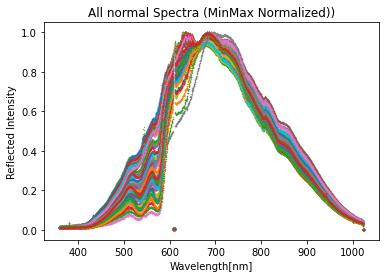

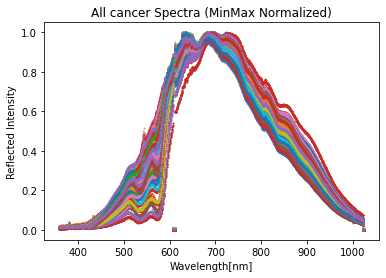

In [18]:
# Normalize the data
data_0_norm = data_0_new.copy()
data_1_norm = data_1_new.copy()
data_0_norm = process.normalize(data_0_norm)
data_1_norm = process.normalize(data_1_norm)

# Plot them again
# Plot all samples of class0 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_0_norm)):
    plt.scatter(data_0_norm[i,:,0] ,data_0_norm[i,:,1],s=0.1)
plt.title('All normal Spectra (MinMax Normalized))')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')

# Plot all samples of class1 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_1_norm)):
    plt.scatter(data_1_norm[i,:,0],data_1_norm[i,:,1],s=0.5)
plt.title('All cancer Spectra (MinMax Normalized)')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')

# # plot one cancer and one normal spectrum on a scatter plot
# plt.figure()
# plt.scatter(data_0_norm[0,:,0],data_0_norm[0,:,1],s=0.5)
# plt.scatter(data_1_norm[0,:,0],data_1_norm[0,:,1],s=0.5)
# plt.title('One cancer and one normal spectrum [MinMax Normalized]')
# plt.xlabel('Wavelength[nm]')
# plt.ylabel('Reflected Intensity')
# plt.legend(['Normal','Cancer'])

In [19]:
# # Plot each spectra using a color map to show how the spectra change over time
# # This is to see if there is any pattern in the spectra
# # use scatter plot to show the data points

# # create the colour map
# cmap = plt.get_cmap('viridis')

# # plot the data with the colour map
# plt.figure()
# for i in range(len(data_1_norm)-1):
#     plt.scatter(data_1_norm[i,:,0],data_1_norm[i,:,1],s=0.1,c=cmap(i/len(data_1_norm)))

# # add a color bar
# sm = plt.cm.ScalarMappable(cmap=cmap)
# sm.set_array([])
# plt.colorbar(sm)

# plt.title('All normal Spectra (MinMax Normalized)')
# plt.xlabel('Wavelength[nm]')
# plt.ylabel('Reflected Intensity')




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

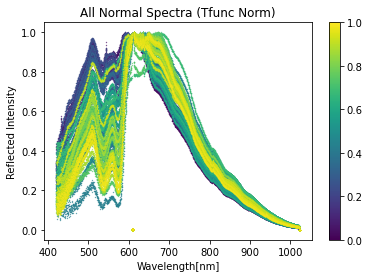

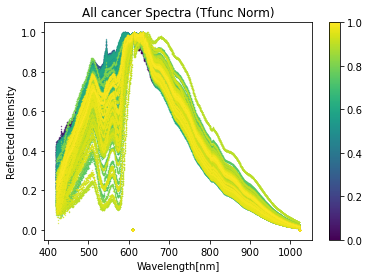

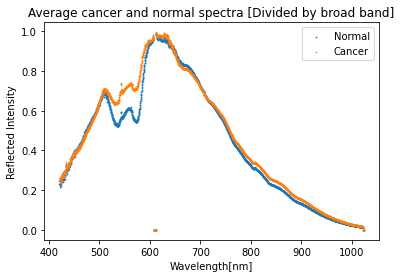

In [20]:
# Load in the baseline 
baseline = baseline_BrOut # --------------------------------- flag
baseline = process.normalize(baseline)[:,1]

data_0_norm = data_0_new[:,280:,:].copy()
data_1_norm = data_1_new[:,280:,:].copy()
baseline = baseline[280:].copy()
tFunc = baseline

def divTfuc(inputData,tFunc):    
    outputData = inputData.copy()
    # For each spectra
    for i in range (inputData[:,:,1].shape[0]):
        data = inputData[i,:,1]
        # Divide by the baseline transfer function
        outputData[i,:,1] = data / tFunc 
    outputData = process.normalize(outputData)
    return outputData
# call the function
data_0_norm_T = divTfuc(data_0_norm,tFunc)
data_1_norm_T = divTfuc(data_1_norm,tFunc)
# Display the arguemtns and output
freq = data_0_norm[0,:,0]

# Plot all samples of class0 on a single figure without using plotSpectra
# assuming data_1_norm_T is the input data array
plotWColourMap(data_0_norm_T, 'All Normal Spectra (Tfunc Norm)', 'Wavelength[nm]', 'Reflected Intensity', )

# Plot all samples of class1 on a single figure using a colour map to denote chronilogical order
# assuming data_1_norm_T is the input data array
plotWColourMap(data_1_norm_T, 'All cancer Spectra (Tfunc Norm)', 'Wavelength[nm]', 'Reflected Intensity')


# plot the average of the cancer spectra and the average of the normal spectra on a scatter plot
plt.figure()
plt.scatter(data_0_norm_T[:,:,0].mean(axis=0),data_0_norm_T[:,:,1].mean(axis=0),s=0.5)
plt.scatter(data_1_norm_T[:,:,0].mean(axis=0),data_1_norm_T[:,:,1].mean(axis=0),s=0.5)
plt.title('Average cancer and normal spectra [Divided by broad band]')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')
plt.legend(['Normal','Cancer'])

In [21]:
data_0_norm = data_0_norm_T
data_1_norm = data_1_norm_T

# # Plots of the normalized spectra
# GUI.plotSpectra(xdata=data_0_norm[0,:,0],ydata=data_0_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Normalized data_0 Spectrum' )
# GUI.plotSpectra(xdata=data_1_norm[0,:,0],ydata=data_1_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Normalized data_1 Spectrum' )

In [22]:
# labels1
# # reindex the labels
# labels1 = labels1.reset_index(drop=True)
# # get the index of cancer
# # cancer_index = labels1[labels1['label'] == 1].index


## Preprocessing Pipeline

In [23]:
def preprocessing_pipeline(Dataset_df,ambient_baseline_df, FLAG_AMBIENT_LIGHT,FLAG_CROP, FLAG_NORMALIZE, FLAG_TFUNC):
    # Step 1: Remove ambient light peak method 1 or 2
    if FLAG_AMBIENT_LIGHT:
        if FLAG_AMBIENT_LIGHT == 1:
            # print(FLAG_AMBIENT_LIGHT)
            data = np.array(Dataset_df['Data'].tolist())
            data = removeAmbientLight_method1(data) # Method 1: Remove just the peak of the ambient light
        if FLAG_AMBIENT_LIGHT == 2:
            # print(FLAG_AMBIENT_LIGHT)
            data = removeAmbientLight_method2(Dataset_df,ambient_baseline_df) # Method 2: Estimate the ambient light for each scan
    else:
        data = np.array(Dataset_df['Data'].tolist())

    # Step 2: Crop the data to 420 nm
    if FLAG_CROP:
        data = data[:,280:,:]

    # Step 3: Normalize the data using minimax
    if FLAG_NORMALIZE: 
        data = process.normalize(data)

    # Step 4: Divide by the baseline transfer function
    if FLAG_TFUNC:
        data = divTfuc(data,tFunc)

    # Step 5: Feature reduction

    processed_data = data.copy()

    # Step 6: Turn the processed data into a singe data column in a dataframe
    data_df = pd.DataFrame()
    for i in range(processed_data.shape[0]):
        new_row = {'Data_preprocessed':processed_data[i,:,:]}
        data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)
    # Add the data to the dataframe
    processedData_df = pd.concat([Dataset_df, data_df], axis=1)
    return processedData_df

## Experiments

In [24]:
# PREPROCSSING THE DATA

# Load in the dataset from file 
file_name = os.path.join(trialPath, dataset_name + '_Formatted_Dataset.csv')
# Load in the dataset
Dataset_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
Dataset_df['Data'] = Dataset_df['Data'].apply(lambda x: np.array(json.loads(x)))

# Load in the ambient light baseline dataframe
ambient_baseline_df = baseline_df.copy()

# Preprocessing flags
FLAG_AMBIENT_LIGHT = 1 # Method 1, Method2, None
FLAG_CROP = True
FLAG_NORMALIZE = True
FLAG_TFUNC = True
FLAG_FEATURE_REDUCTION = False

processedData_df = preprocessing_pipeline(Dataset_df,ambient_baseline_df, FLAG_AMBIENT_LIGHT,FLAG_CROP, FLAG_NORMALIZE, FLAG_TFUNC)

## 3D PCA trials

### PCA fitting

In [25]:
from sklearn.decomposition import PCA
# Get the data from the dataframe
data = np.array(processedData_df['Data_preprocessed'].tolist())[:,:,1]
# Create the PCA object
pca = PCA(n_components=3)
# Fit the PCA object to the data
pca.fit(data)
# Transform the data
data_pca = pca.fit_transform(data)
# Create a dataframe with the PCA data
data_pca_df = pd.DataFrame(data_pca, columns=['PCA1','PCA2','PCA3'])
# Add the PCA data to the dataframe
data_pca_df = pd.concat([processedData_df, data_pca_df], axis=1)
# data_pca_df

### PCA - Class separation

In [26]:
import plotly.express as px

bigPlot = False
if bigPlot:
    figSize = (800,800)
else:
    figSize = (400,400)
    
# Create a 3D PCA plot of cancer vs normal
fig = px.scatter_3d(data_pca_df, x='PCA1', y='PCA2', z='PCA3',title='3D PCA: Cancer vs Normal', color='Label', opacity=0.8, color_discrete_sequence=['orange','blue','orange','orange','orange'])
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=figSize[0], height=figSize[1],title_x=0.5, title_y=0.8,legend=dict(x=0.8, y=0.8))
fig.show()
# Create a 3D plot of all classes in the dataset
# color_discrete_sequence=['yellow','blue','orange','pink','red']
fig = px.scatter_3d(data_pca_df, x='PCA1', y='PCA2', z='PCA3',title='3D PCA: all classes in the dataset', color='Label', opacity=0.8, color_discrete_sequence=['yellow','blue','orange','pink','red'])
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=figSize[0], height=figSize[1],title_x=0.5, title_y=0.8,legend=dict(x=0.8, y=0.8))
fig.show()


### PCA - Sample separation

In [27]:
bigPlot = False
if bigPlot:
    figSize = (800,800)
else:
    figSize = (400,400)
# 3D PCA: Sample1 vs Sample2 vs Sample3
fig = px.scatter_3d(data_pca_df, x='PCA1', y='PCA2', z='PCA3',title='3D PCA: Sample1 vs Sample2 vs Sample3', color='SampleID', opacity=0.8, color_discrete_sequence=['orange','orange','red','red','pink','pink'])
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=figSize[0], height=figSize[1],title_x=0.5, title_y=0.8,legend=dict(x=0.8, y=0.8))
fig.show()

# 3D PCA: plot pf cancer vs normal for sample 1 and 3
data_1_3_df = data_pca_df[data_pca_df['SampleID'].str.contains('Sample1|Sample3')]
fig = px.scatter_3d(data_1_3_df, x='PCA1', y='PCA2', z='PCA3',title='3D PCA: plot pf cancer vs normal for sample 1 and 3', color='Label', opacity=0.8, color_discrete_sequence=['orange','blue','orange','orange','orange','orange'])
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=figSize[0], height=figSize[1],title_x=0.5, title_y=0.8,legend=dict(x=0.8, y=0.8))
fig.show()

In [28]:
bigPlot = False
if bigPlot:
    figSize = (800,800)
else:
    figSize = (400,400)
# 3D PCA: plot pf cancer vs normal for sample 1 and 3
# get the sample ID which contain Sample1 and Sample3
data_1_3_df = data_pca_df[data_pca_df['SampleID'].str.contains('Sample1|Sample3')]
# print size of data_1_3_df
print('Size of data_1_3_df: ',data_1_3_df.shape)
fig = px.scatter_3d(data_pca_df, x='PCA1', y='PCA2', z='PCA3',title='3D PCA: all classes in the dataset', color='Label', opacity=0.8, color_discrete_sequence=['yellow','blue','orange','pink','red'])
fig.update_traces(marker=dict(size=5))

fig.update_layout(width=figSize[0], height=figSize[1],title_x=0.5, title_y=0.8,legend=dict(x=0.8, y=0.8))
fig.show()

Size of data_1_3_df:  (287, 10)


### Combination graph - class and sample


In [29]:
import plotly.graph_objects as go

bigPlot = True
if bigPlot:
    figSize = (800,800)
else:
    figSize = (400,400)
# 3D PCA: Sample1 vs Sample2 vs Sample3
''' 
Combine the information from the graphs above: 
Create a 3D plot which contains all the samples colour coded by sample number
also encode the classes in terms of shapes
    For example:
    Sample1_back (cancer):  light blue circle-open
    Sample1_back (normal):  light blue cross
    Sample1_front (cancer): blue circle-open
    Sample1_front (normal): blue cross
    Sample2_back (cancer):  light red circle-open
    Sample2_back (normal):  light red cross
    ...
The main dataframe has the following columns:
    SampleID. Contains the sample ID
    Label. Contains the class of the sample
    Label (numeric). Contains the class of the sample encoded as a number
    PCA1. Contains the PCA1 value
    PCA2. Contains the PCA2 value
    PCA3. Contains the PCA3 value
'''
# Create a 3D plot
labels = np.unique(data_pca_df['SampleID'])
# change the colours to be Blue, slightly ligher blue, red, slightly ligher red, green, lighter green
colours = ['#0000FF', '#99CCFF', '#FF0000', '#FF9999', '#008000', '#99CC99']
shapes = ['circle-open','cross']


fig = go.Figure()
for label, colour in zip(labels, colours):
    df = data_pca_df[data_pca_df['SampleID'] == label]
    marker_shapes = [shapes[int(x)] for x in df['Label (numeric)']]
    fig.add_trace(go.Scatter3d(
        x=df['PCA1'], 
        y=df['PCA2'], 
        z=df['PCA3'], 
        mode='markers', 
        marker=dict(size=5, color=colour, symbol=marker_shapes),
        name=label
    ))

# combine the update_layout into a single statement
fig.update_layout(
    # change aspects of the graph
    scene=dict(
        xaxis_title='PCA1', yaxis_title='PCA2', zaxis_title='PCA3'
        # ,xaxis=dict(range=[-5, 5]), 
        # yaxis=dict(range=[-5, 5]), 
        # zaxis=dict(range=[-5, 5])
        ),
    width= figSize[0],
    height= figSize[1],
    title='3D PCA: Combination graph (Class: Shape, SampleID: Colour)',
    # Change title and legend position
    title_x=0.5, title_y= 0.8,
    legend=dict(x=0.8, y=0.8)
    )




fig.show()


In [30]:
bigPlot = True
if bigPlot:
    figSize = (800,800)
else:
    figSize = (400,400)
''' 
Combine the information from the graphs above: 
Create a 3D plot which contains all the samples colour coded by sample number
also encode the classes in terms of shapes
    For example:
    Sample1_back (cancer):  blue circle-open
    Sample1_back (normal):  orange blue circle-open
    Sample1_front (cancer): blue circle
    Sample1_front (normal): orange circle
    Sample2_back (cancer):  blue red square-open
    Sample2_back (normal):  orange red square-open
    ...
The main dataframe has the following columns:
    SampleID. Contains the sample ID
    Label. Contains the class of the sample
    Label (numeric). Contains the class of the sample encoded as a number
    PCA1. Contains the PCA1 value
    PCA2. Contains the PCA2 value
    PCA3. Contains the PCA3 value
'''
# Create a 3D plot
labels = np.unique(data_pca_df['SampleID'])

# Change the colors to be blue for label 0 and red for label 1
colors = {0: 'blue', 1: 'orange'}
# Change the shapes to be different for each sample ID
shapes = ['circle','circle-open','square','square-open', 'diamond','diamond-open']

fig = go.Figure()
count = -1
for label in labels:
    count = count + 1
    df = data_pca_df[data_pca_df['SampleID'] == label]
    marker_colors = [colors[x] for x in df['Label (numeric)']]
    # This marker appears to be chosen randomly
    # marker_symbols = [shapes[i % len(shapes)] for i in range(len(df))]
    # Here is the line to choose the marker based on the sample ID
    marker_symbols = [shapes[count] for i in range(len(df))]


    fig.add_trace(go.Scatter3d(
        x=df['PCA1'], 
        y=df['PCA2'], 
        z=df['PCA3'], 
        mode='markers', 
        marker=dict(size=5, color=marker_colors, symbol=marker_symbols),
        name=label
    ))

fig.update_layout(
    scene=dict(xaxis_title='PCA1', yaxis_title='PCA2', zaxis_title='PCA3'), 
    width=figSize[0], 
    height=figSize[1],
    title='3D PCA: Combination graph (Class: Colour, SampleID: Shape)'
)

# move the title down
fig.update_layout(title_x=0.5, title_y=0.8)
# move the legend down
fig.update_layout(legend=dict(x=0.8, y=0.8))

fig.show()




### PCA over time: Analyzing the shift of the cancer over time for each sample


In [31]:
'''
bigPlot = False
if bigPlot:
    figSize = (800,800)
else:
    figSize = (400,400)
# Analyzing the shift of the cancer over time for each sample
sampleLabel = 1 # 0 for Sample1_back, 1 for Sample1_front, 2 for Sample2_back, 3 for Sample2_front, 4 for Sample3_back, 5 for Sample3_front
histopathologyLabel = 1 # 0 for normal, 1 for cancer
#if histopathologylabel is 0, histopathologyLabelText is 'normal', else it is normal 
if histopathologyLabel ==0:
    histopath = 'Normal'
else:
    histopath = 'Cancer'

# Get the desired histopathology from dataframe
data_desiredPathology_df = data_pca_df[data_pca_df['Label (numeric)'] == histopathologyLabel]
# Get uniqiue ids from the SampleID column
unique_ids = data_pca_df['SampleID'].unique()


# Get desired sample from dataset
data_desiredPathology_df = data_desiredPathology_df[data_desiredPathology_df['SampleID'] == unique_ids[sampleLabel]]

# fit a pca model to the cancer samples
pca = PCA(n_components=3)
pca.fit(data_desiredPathology_df[['PCA1','PCA2','PCA3']])
# transform the data
data_desiredPathology_df[['PCA1','PCA2','PCA3']] = pca.transform(data_desiredPathology_df[['PCA1','PCA2','PCA3']])

# remove the first row from the dataframe
data_desiredPathology_df = data_desiredPathology_df.iloc[4:]

# create the title of the plot
title = f'3D PCA: {histopath} samples for {unique_ids[sampleLabel]}'

time = data_desiredPathology_df['Time']
# Subtract the first time point from the rest of the time points
time = time - time.iloc[0]
# print the start and end time in minutes and seconds
timeStart = time.iloc[0] 
# Reformat time to minutes and seconds

print('Start time: ',time.iloc[0],' minutes')
print('End time: ',time.iloc[-1],' minutes')

# plot the cancer samples with the colour corresponding to the time column
SECONDS_PER_MINUTE = 60
fig = px.scatter_3d(data_desiredPathology_df, x='PCA1', y='PCA2', z='PCA3',title=title, color=time/SECONDS_PER_MINUTE, opacity=0.8, color_discrete_sequence=['yellow','blue','orange','pink','red'])
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=np.floor(figSize[0]*1.5), height=figSize[1],title_x=0.5, title_y=0.8,legend=dict(x=0.8, y=0.8),coloraxis_colorbar=dict(x=0.8, title='Time (minutes)'))

fig.show()
'''

"\nbigPlot = False\nif bigPlot:\n    figSize = (800,800)\nelse:\n    figSize = (400,400)\n# Analyzing the shift of the cancer over time for each sample\nsampleLabel = 1 # 0 for Sample1_back, 1 for Sample1_front, 2 for Sample2_back, 3 for Sample2_front, 4 for Sample3_back, 5 for Sample3_front\nhistopathologyLabel = 1 # 0 for normal, 1 for cancer\n#if histopathologylabel is 0, histopathologyLabelText is 'normal', else it is normal \nif histopathologyLabel ==0:\n    histopath = 'Normal'\nelse:\n    histopath = 'Cancer'\n\n# Get the desired histopathology from dataframe\ndata_desiredPathology_df = data_pca_df[data_pca_df['Label (numeric)'] == histopathologyLabel]\n# Get uniqiue ids from the SampleID column\nunique_ids = data_pca_df['SampleID'].unique()\n\n\n# Get desired sample from dataset\ndata_desiredPathology_df = data_desiredPathology_df[data_desiredPathology_df['SampleID'] == unique_ids[sampleLabel]]\n\n# fit a pca model to the cancer samples\npca = PCA(n_components=3)\npca.fit(data_

In [32]:
'''
bigPlot = True
if bigPlot:
    figSize = (700,700)
else:
    figSize = (400,400)
# Analyzing the shift of the cancer over time for each sample
histopathologyLabel = 0 # 0 for normal, 1 for cancer
for histopathologyLabel in range(2):
    #if histopathologylabel is 0, histopathologyLabelText is 'normal', else it is normal 
    if histopathologyLabel ==0:
        histopath = 'Normal'
    else:
        histopath = 'Cancer'

    # Get the desired histopathology from dataframe
    data_desiredPathology_df_saved = data_pca_df[data_pca_df['Label (numeric)'] == histopathologyLabel].copy()
    # Get uniqiue ids from the SampleID column
    unique_ids = data_desiredPathology_df_saved['SampleID'].unique()
    print(f'OVERVIEW INFORMATION for {histopath}:')
    print(f'Samples which contain {histopath}:',unique_ids)
    # here is the current object Index(['PatientID', 'SampleID', 'Label (numeric)', 'Label', 'Data', 'Time', 'Data_preprocessed', 'PCA1', 'PCA2', 'PCA3'], dtype='object')
    # Add an additional empty column to the dataframe that contains the absolute time to be calculated from the time column
    data_desiredPathology_df_saved['Time_abs'] = np.nan
    data_desiredPathology_df_saved.head()

    # print size of the dataframe
    print('REMOVE TEST READINGS FROM EACH SAMPLE SET')
    print('Size of dataframe before removing samples:',data_desiredPathology_df_saved.shape)
    # for each sample in data_desiredPathology_df_saved, remove the first x samples from the dataframe
    if histopathologyLabel == 1:
        samples_to_remove = [1,1,1,4,3,4]
    else:
        samples_to_remove = [0,1,0,0]
    for sampleLabel in range(len(samples_to_remove)):
        n = samples_to_remove[sampleLabel]
        labelName = unique_ids[sampleLabel]
        # get the index of the first n occurences of labelName
        indexNames = data_desiredPathology_df_saved[data_desiredPathology_df_saved['SampleID'] == labelName].iloc[:n].index
        # Delete these row indexes from dataFrame
        data_desiredPathology_df_saved.drop(indexNames , inplace=True)
        # print which rows were deleted
    print('Size of dataframe after removing samples:',data_desiredPathology_df_saved.shape)

    # For each sample, subtract the first time point from the rest of the time points
    for sampleLabel in range(len(samples_to_remove)):
        # Get desired sample from dataset
        data_desiredPathology_df = data_desiredPathology_df_saved[data_desiredPathology_df_saved['SampleID'] == unique_ids[sampleLabel]].copy()
        time = data_desiredPathology_df['Time']
        start_time = time.iloc[0]
        # For each time in the data_desiredPathology_df, subtract the start time
        time_abs = time - start_time
        # Add the time_abs column to the data_desiredPathology_df
        SECONDS_PER_MINUTE = 60
        data_desiredPathology_df['Time_abs'] = time_abs/SECONDS_PER_MINUTE
        # merge this back into the data_desiredPathology_df_saved
        data_desiredPathology_df_saved[data_desiredPathology_df_saved['SampleID'] == unique_ids[sampleLabel]] = data_desiredPathology_df
    data_desiredPathology_df_saved

    # create the title of the plot
    title = f'3D PCA: {histopath} samples over time'
    # plot the cancer samples with the colour corresponding to the time column
    SECONDS_PER_MINUTE = 60
    fig = px.scatter_3d(data_desiredPathology_df_saved, x='PCA1', y='PCA2', z='PCA3',title=title, color='Time_abs', opacity=0.8, color_continuous_scale='viridis')
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(width=np.floor(figSize[0]*1.5), height=figSize[1],title_x=0.5, title_y=0.8,legend=dict(x=0.8, y=0.8),coloraxis_colorbar=dict(x=0.8, title='Time (minutes)'))
    fig.show()
    
'''

"\nbigPlot = True\nif bigPlot:\n    figSize = (700,700)\nelse:\n    figSize = (400,400)\n# Analyzing the shift of the cancer over time for each sample\nhistopathologyLabel = 0 # 0 for normal, 1 for cancer\nfor histopathologyLabel in range(2):\n    #if histopathologylabel is 0, histopathologyLabelText is 'normal', else it is normal \n    if histopathologyLabel ==0:\n        histopath = 'Normal'\n    else:\n        histopath = 'Cancer'\n\n    # Get the desired histopathology from dataframe\n    data_desiredPathology_df_saved = data_pca_df[data_pca_df['Label (numeric)'] == histopathologyLabel].copy()\n    # Get uniqiue ids from the SampleID column\n    unique_ids = data_desiredPathology_df_saved['SampleID'].unique()\n    print(f'OVERVIEW INFORMATION for {histopath}:')\n    print(f'Samples which contain {histopath}:',unique_ids)\n    # here is the current object Index(['PatientID', 'SampleID', 'Label (numeric)', 'Label', 'Data', 'Time', 'Data_preprocessed', 'PCA1', 'PCA2', 'PCA3'], dtype='

In [33]:
bigPlot = True
if bigPlot:
    figSize = (700,700)
else:
    figSize = (400,400)
# Analyzing the shift of the cancer over time for each sample
histopathologyLabel = 1 # 0 for normal, 1 for cancer
for histopathologyLabel in range(2):
    #if histopathologylabel is 0, histopathologyLabelText is 'normal', else it is normal 
    if histopathologyLabel ==0:
        histopath = 'Normal'
    else:
        histopath = 'Cancer'

    # Get the desired histopathology from dataframe
    data_desiredPathology_df_saved = data_pca_df[data_pca_df['Label (numeric)'] == histopathologyLabel].copy()
    # Get uniqiue ids from the SampleID column
    unique_ids = data_desiredPathology_df_saved['SampleID'].unique()
    print(f'OVERVIEW INFORMATION for {histopath}:')
    print(f'Samples which contain {histopath}:',unique_ids)
    # here is the current object Index(['PatientID', 'SampleID', 'Label (numeric)', 'Label', 'Data', 'Time', 'Data_preprocessed', 'PCA1', 'PCA2', 'PCA3'], dtype='object')
    # Add an additional empty column to the dataframe that contains the absolute time to be calculated from the time column
    data_desiredPathology_df_saved['Time_abs'] = np.nan
    data_desiredPathology_df_saved.head()

    # print size of the dataframe
    print('REMOVE TEST READINGS FROM EACH SAMPLE SET')
    print('Size of dataframe before removing samples:',data_desiredPathology_df_saved.shape)
    # for each sample in data_desiredPathology_df_saved, remove the first x samples from the dataframe
    if histopathologyLabel == 1:
        samples_to_remove = [1,1,1,4,3,4]
    else:
        samples_to_remove = [0,1,0,0]
    for sampleLabel in range(len(samples_to_remove)):
        n = samples_to_remove[sampleLabel]
        labelName = unique_ids[sampleLabel]
        # get the index of the first n occurences of labelName
        indexNames = data_desiredPathology_df_saved[data_desiredPathology_df_saved['SampleID'] == labelName].iloc[:n].index
        # Delete these row indexes from dataFrame
        data_desiredPathology_df_saved.drop(indexNames , inplace=True)
        # print which rows were deleted
    print('Size of dataframe after removing samples:',data_desiredPathology_df_saved.shape)

    # For each sample, subtract the first time point from the rest of the time points
    for sampleLabel in range(len(samples_to_remove)):
        # Get desired sample from dataset
        data_desiredPathology_df = data_desiredPathology_df_saved[data_desiredPathology_df_saved['SampleID'] == unique_ids[sampleLabel]].copy()
        time = data_desiredPathology_df['Time']
        start_time = time.iloc[0]
        # For each time in the data_desiredPathology_df, subtract the start time
        time_abs = time - start_time
        # Add the time_abs column to the data_desiredPathology_df
        SECONDS_PER_MINUTE = 60
        data_desiredPathology_df['Time_abs'] = time_abs/SECONDS_PER_MINUTE
        # merge this back into the data_desiredPathology_df_saved
        data_desiredPathology_df_saved[data_desiredPathology_df_saved['SampleID'] == unique_ids[sampleLabel]] = data_desiredPathology_df


    import plotly.graph_objs as go
    # Make a dictionary of the shapes for each sample label
    symbol_dict = {'Sample1_back': 'circle',
                'Sample1_front': 'circle',
                'Sample2_back': 'square',
                'Sample2_front': 'square',
                'Sample3_back': 'diamond',
                'Sample3_front': 'diamond'
                }

    # create a trace for each sample label with different marker shapes
    traces = []
    for label in np.unique(data_desiredPathology_df_saved['SampleID']):
        idx = data_desiredPathology_df_saved['SampleID'] == label
        trace = go.Scatter3d(
            x=data_desiredPathology_df_saved['PCA1'][idx],
            y=data_desiredPathology_df_saved['PCA2'][idx],
            z=data_desiredPathology_df_saved['PCA3'][idx],
            mode='markers',
            marker=dict(
                size=5, symbol=symbol_dict[label], opacity=0.8, color=data_desiredPathology_df_saved['Time_abs'][idx],
                colorscale='viridis', colorbar=dict(title='Time (minutes)'), coloraxis='coloraxis'
            ),
            name=label,
            hovertemplate='PCA1: %{x:.2f}<br>PCA2: %{y:.2f}<br>PCA3: %{z:.2f}<br>Time: %{marker.color:.2f} minutes'
        )
        traces.append(trace)

    # define the layout of the plot
    layout = go.Layout(
        title=dict(x=0.5, y=0.8),#,text=f'3D PCA: {histopath} samples over time'),
        width=np.floor(figSize[0]*1.5),
        height=figSize[1],
        scene=dict(xaxis_title='PCA1', yaxis_title='PCA2', zaxis_title='PCA3')#, xaxis=dict(range=[-5, 10]), yaxis=dict(range=[-4, 4]), zaxis=dict(range=[-1, 3])),
        ,legend=dict(x=0.05, y=0.8),
        coloraxis=dict(colorbar=dict(x=0.8, title='Time (minutes)'), colorscale='viridis'),#  'jet'),

    )
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

OVERVIEW INFORMATION for Normal:
Samples which contain Normal: ['Sample1_back' 'Sample1_front' 'Sample3_back' 'Sample3_front']
REMOVE TEST READINGS FROM EACH SAMPLE SET
Size of dataframe before removing samples: (84, 11)
Size of dataframe after removing samples: (83, 11)


OVERVIEW INFORMATION for Cancer:
Samples which contain Cancer: ['Sample1_back' 'Sample1_front' 'Sample2_back' 'Sample2_front'
 'Sample3_back' 'Sample3_front']
REMOVE TEST READINGS FROM EACH SAMPLE SET
Size of dataframe before removing samples: (315, 11)
Size of dataframe after removing samples: (301, 11)


In [34]:
# #plot the cancer samples with the colour corresponding to the time column
# # Set marker symbols for each unique sample label
# if histopathologyLabel == 1:
#     symbol_sequence = ['circle','circle-open','square','square-open', 'diamond','diamond-open']
#     symbol_sequence = ['circle','circle','circle','circle','circle','circle']

# else:
#     symbol_sequence = ['circle','circle-open','diamond','diamond-open']
#     symbol_sequence = ['circle', 'circle', 'circle', 'circle']

# # create the title of the plot
# title = f'3D PCA: {histopath} samples over time'
# #plot the cancer samples with the colour corresponding to the time column and different marker shapes for each sample label
# fig = px.scatter_3d(data_desiredPathology_df_saved, x='PCA1', y='PCA2', z='PCA3',
#                     title=title, color='Time_abs', opacity=0.8, color_continuous_scale='viridis',
#                     symbol='SampleID', symbol_sequence=symbol_sequence)
# fig.update_traces(marker=dict(size=5))
# fig.update_layout(
#     # Change figure dimensions
#     width=np.floor(figSize[0]*1.5), 
#     height=figSize[1],
#     # Change element positions
#     title_x=0.5, 
#     title_y=0.8,
#     legend=dict(x=0.1, y=0.8),
#     coloraxis_colorbar=dict(x=0.8, title='Time (minutes)'),
# )
# fig.show()

## 3D LDA trials

### 3D LDA - data splitting

In [35]:
''' 
Description: LDA dimensionality is limited by the number of classes. 
To create a 3D LDA we need to split each cancer and normal class into two classes.

'''
# Create a copy of the dataframe
proData_3DLDA_df = processedData_df.copy()
# For Label (numeric label) = 1, change half the Labels to 'cancer1' and the other half to 'cancer2'
proData_3DLDA_df.loc[proData_3DLDA_df['Label (numeric)'] == 1, 'Label'] = np.where(np.random.rand(len(proData_3DLDA_df[proData_3DLDA_df['Label (numeric)'] == 1])) > 0.5, 'cancer1', 'cancer2')
# Also renumber the numberic label from 1 to 2 for cancer1 and 3 for cancer2
proData_3DLDA_df.loc[proData_3DLDA_df['Label'] == 'cancer1', 'Label (numeric)'] = 2
proData_3DLDA_df.loc[proData_3DLDA_df['Label'] == 'cancer2', 'Label (numeric)'] = 3

# Do the same for normal but change the numeric label to 0 and 1
proData_3DLDA_df.loc[proData_3DLDA_df['Label (numeric)'] == 0, 'Label'] = np.where(np.random.rand(len(proData_3DLDA_df[proData_3DLDA_df['Label (numeric)'] == 0])) > 0.5, 'normal1', 'normal2')
proData_3DLDA_df.loc[proData_3DLDA_df['Label'] == 'normal1', 'Label (numeric)'] = 0
proData_3DLDA_df.loc[proData_3DLDA_df['Label'] == 'normal2', 'Label (numeric)'] = 1

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


### 3D LDA - All data for train

In [36]:
'''
# define font sizes
fontTitle = 20
fontLabel = 16

# Proceed with LDA on the data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Get the data from the dataframe
data = np.array(proData_3DLDA_df['Data_preprocessed'].tolist())[:,:,1]
# Get the labels from the dataframe
labels = np.array(proData_3DLDA_df['Label (numeric)'].tolist())

# Create the LDA object
lda = LinearDiscriminantAnalysis(n_components=3)
# Fit the LDA object to the data and labels
lda.fit(data, labels)
# Transform the data
data_lda = lda.transform(data)
print(data_lda.shape)
# Create a dataframe with the LDA data
data_lda_df = pd.DataFrame(data_lda, columns=['LDA1','LDA2','LDA3'])
# Add the LDA data to the dataframe
data_3Dlda_df = pd.concat([proData_3DLDA_df, data_lda_df], axis=1)
# data_3Dlda_df

# 3D LDA plot of cancer vs normal
labels = np.unique(data_3Dlda_df['Label'])

fig = px.scatter_3d(data_3Dlda_df, x='LDA1', y='LDA2', z='LDA3', color='Label', opacity=0.7, width=figSize[0], height=figSize[1]
                    ,color_discrete_sequence=['yellow','blue','orange','pink'])
fig.update_layout(title='3D LDA: cancer vs normal', title_x=0.5, title_font_size=fontTitle, legend_title_text='Label', legend_title_font_size=fontLabel, font_size=fontLabel)
# lower the title and the legend
fig.update_layout(title_y=0.7, legend_y=0.7, legend_x=0.8)
fig.show()
'''



"\n# define font sizes\nfontTitle = 20\nfontLabel = 16\n\n# Proceed with LDA on the data\nfrom sklearn.discriminant_analysis import LinearDiscriminantAnalysis\n\n# Get the data from the dataframe\ndata = np.array(proData_3DLDA_df['Data_preprocessed'].tolist())[:,:,1]\n# Get the labels from the dataframe\nlabels = np.array(proData_3DLDA_df['Label (numeric)'].tolist())\n\n# Create the LDA object\nlda = LinearDiscriminantAnalysis(n_components=3)\n# Fit the LDA object to the data and labels\nlda.fit(data, labels)\n# Transform the data\ndata_lda = lda.transform(data)\nprint(data_lda.shape)\n# Create a dataframe with the LDA data\ndata_lda_df = pd.DataFrame(data_lda, columns=['LDA1','LDA2','LDA3'])\n# Add the LDA data to the dataframe\ndata_3Dlda_df = pd.concat([proData_3DLDA_df, data_lda_df], axis=1)\n# data_3Dlda_df\n\n# 3D LDA plot of cancer vs normal\nlabels = np.unique(data_3Dlda_df['Label'])\n\nfig = px.scatter_3d(data_3Dlda_df, x='LDA1', y='LDA2', z='LDA3', color='Label', opacity=0.7,

### 3D LDA - Train test split experiments

In [37]:
def create3DLDA(trainData_df, testData_df, figSize,title,aspectratio=dict(x=1, y=1, z=1)):

    # instantiate the LDA object
    lda = LinearDiscriminantAnalysis(n_components=3)
    # Train data
    train_X = np.array(trainData_df['Data_preprocessed'].tolist())[:,:,1]
    train_y = np.array(trainData_df['Label (numeric)'].tolist())
    # fit the LDA object to the data and labels
    lda.fit(train_X, train_y)

    # Test data
    test_X = np.array(testData_df['Data_preprocessed'].tolist())[:,:,1]
    # Transform the data
    test_X_lda = lda.transform(test_X)
    # Create a dataframe with the LDA data
    test_X_lda_df = pd.DataFrame(test_X_lda, columns=['LDA1','LDA2','LDA3'])
    # copy the backData_df and add the LDA data to the dataframe
    test_X_lda_df = pd.concat([testData_df, test_X_lda_df], axis=1)
    # 3D LDA plot of cancer vs normal
    fig = px.scatter_3d(
        test_X_lda_df, 
        x='LDA1', y='LDA2', z='LDA3', 
        color=test_X_lda_df['Label'], 
        opacity=0.7, width=figSize[0], height=figSize[1],
        color_discrete_sequence=['orange','orange','blue','blue'],
        symbol=test_X_lda_df['Label'], symbol_sequence=['circle','circle-open','square','square-open'],
        # symbol=test_X_lda_df['SampleID'], symbol_sequence=['circle','circle-open','square','square-open','diamond','diamond-open']
        # symbol='SampleID', symbol_sequence=['circle', 'circle-open','square','square-open']
        hover_data=['SampleID','LDA1','LDA2','LDA3','Label'],
    )
    fig.update_layout(title=dict(text=title, x=0.5, y=0.7), legend = dict(title='Label',y=0.7, x=0.8))
    # update the axes so they have the same scale
    # fig.update_layout(scene_aspectmode='cube')
    fig.update_layout(scene=dict(aspectratio=aspectratio))
    fig.show()

In [38]:
from sklearn.model_selection import train_test_split
bigPlot = True
if bigPlot:
    figSize = (700,700)
else:
    figSize = (400,400)
# 3D LDA - Train on back test of front

# Get the front and back data separately. The SampleID will contain front or back
frontData_df = proData_3DLDA_df[proData_3DLDA_df['SampleID'].str.contains('front')].reset_index(drop=True)
backData_df = proData_3DLDA_df[proData_3DLDA_df['SampleID'].str.contains('back')].reset_index(drop=True)

'''Experiment 1: random train test splits'''
# split the train and test randomly 30% test, 70% train
trainData_df, testData_df = train_test_split(proData_3DLDA_df, test_size=0.3, random_state=41)
# create3DLDA(trainData_df=trainData_df.reset_index(drop=True), testData_df=testData_df.reset_index(drop=True), figSize=figSize, title='LDA: Random Train70 - Test30')
# Remove sample 1 back from the data and run the LDA again
trainData_df = trainData_df[trainData_df['SampleID'] != 'Sample1_back'].reset_index(drop=True)
testData_df = testData_df[testData_df['SampleID'] != 'Sample1_back'].reset_index(drop=True)
create3DLDA(trainData_df=trainData_df.reset_index(drop=True), testData_df=testData_df.reset_index(drop=True), figSize=figSize, title='LDA: Random Train70 - Test30, Sample1_back removed')

'''Experiment 2: train on back, test on front'''
trainData_df = frontData_df
testData_df = backData_df
# create3DLDA(trainData_df=frontData_df, testData_df=backData_df, figSize=figSize, title='LDA: Train-Test, Front-Back')
# create3DLDA(trainData_df=backData_df, testData_df=frontData_df, figSize=figSize, title='LDA: Train=Test, Back-Front')

'''Experiment 3: leave 1 out cross validation. Train on 5 samples, test on 1 sample'''
# Get the unique sample IDs
unique_ids = proData_3DLDA_df['SampleID'].unique()
# systematically create a train and test set
for i in range(len(unique_ids)):
    # get the test sample
    testData_df = proData_3DLDA_df[proData_3DLDA_df['SampleID'] == unique_ids[i]].reset_index(drop=True)
    # get the train samples
    trainData_df = proData_3DLDA_df[proData_3DLDA_df['SampleID'] != unique_ids[i]].reset_index(drop=True)
    # create3DLDA(trainData_df=trainData_df, testData_df=testData_df, figSize=figSize, title=f'LDA: Leave 1 out validation test sample: {unique_ids[i]}')




### PCA LDA classification


In [39]:
'''PCA LDA functions'''
'''
Now that I have interrogated PCA and LDA separately through a graphical representation, I will now combine the two methods to see if I can improve the classification accuracy.
Steps:
1. Get the data from the processedData_df and store it in a new dataframe called data_PCALDA_df
2. Separate the data into train and test sets
3. Perform PCA on the train data - selecting a subset of principal components
4. Fit a LDA classifier to the PCA data
5. Evaluate the performance of the PCA-LDA classifier on the test data

'''
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

''' The folowing function creates a PCA LDA pipeline and returns the fit pipeline'''
def fit_PCA_LDA(trainData_df, n_components=190):
    # extract the train data
    # Extract Train data
    train_X = np.array(trainData_df['Data_preprocessed'].tolist())[:,:,1]
    train_y = np.array(trainData_df['Label (numeric)'].tolist())

    # n_components must be between 0 and min(n_samples, n_features)=279
    n_features = train_X.shape[1]
    n_samples = train_X.shape[0]
    if n_components > min(n_samples, n_features):
        n_components = int(np.ceil(min(n_samples, n_features)*(2/3)))
        np.ceil
        print(f'n_components must be between 0 and min(n_samples, n_features), set to 2/3 max: {n_components}')

    # Step 1: Perform PCA on training data
    pca = PCA(n_components=n_components) # Note the recommended number of components is 1/3 of the total number of features - about 1000 here
    pca.fit_transform(train_X)
    train_X_pca = pca.transform(train_X)

    # Step 2: Perform LDA on the transformed data to build a classifier
    lda = LDA()
    lda.fit(train_X_pca, train_y)
    pca_lda_classifier = make_pipeline(pca, lda)

    # return the trained classifier
    return pca_lda_classifier

''' The following function takes in test data and a fit PCA-LDA pipeline and returns the results of the classifier'''
def evaluate_PCA_LDA(testData_df, classifier, expName='Specify classifier type', average='binary', BY_SAMPLE=False, CM_FLAG=True):
    print(f'{expName} Results:')
    # Extract Test data
    test_X = np.array(testData_df['Data_preprocessed'].tolist())[:, :, 1]
    test_y = np.array(testData_df['Label (numeric)'].tolist())

    # Evaluate the performance of the classifier on the test data
    y_pred = classifier.predict(test_X)
    # Add the predicted labels to the dataframe
    testData_df['Predicted Label'] = y_pred # I think this is the source of the warning

    # Calculate all of the desired metrics: Accuracy, Precision, Recall, F1
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, average=average)
    recall = recall_score(test_y, y_pred, average=average)
    f1 = f1_score(test_y, y_pred, average=average)
    # display the calculated results in an aesthetic table
    results_df = pd.DataFrame({'Accuracy': [accuracy], 'Precision' : [precision], 'Recall' : [recall], 'F1' : [f1]}).round({'Value': 2})
    display(results_df)

    if CM_FLAG:
        # Display the overall confusion matrix
        cm = confusion_matrix(test_y, y_pred)
        # show shape of cm
        print('Confusion Matrix Shape:',cm.shape)
        unique_testy = np.unique(test_y)
        unique_predy = np.unique(y_pred)
        print('Unique test_y:',unique_testy)
        print('Unique y_pred:',unique_predy)
        classes = np.unique(np.concatenate((unique_testy,unique_predy)))
        # classes = ['normal', 'cancer']
        # classes = [1,2, 3]
        cm_df = pd.DataFrame(cm, index=classes, columns=classes)
        display(cm)
        displayCM(cm_df, expName=expName)

    if BY_SAMPLE:
        # Display the confusion matrix broken down by sampleID
        cm_dfs, sampleIDs = cmSampleBreakdown(testData_df)
        for i in range(len(cm_dfs)):
            displayCM(cm_dfs[i], expName=f'{expName}: {sampleIDs[i]}')


    return results_df
# define a function to create the confusion matrix breakdown by sampleID
def cmSampleBreakdown(testData_df):
    '''
    Display the confusion matrix broken down by sampleID.
    This offers much more infomration about where the incorrect classifications came from.
    The predictions are stored in the 'Predicted Label' column
    The actual labels are stored in the 'Label (numeric)' column
    '''
    unique_ids = testData_df['SampleID'].unique()
    cm_dfs = []
    for i in range(len(unique_ids)):
        # get the actual labels for the sample
        actual_labels = testData_df[testData_df['SampleID'] == unique_ids[i]]['Label (numeric)']
        # get the predicted labels for the sample
        predicted_labels = testData_df[testData_df['SampleID'] == unique_ids[i]]['Predicted Label']
        # calculate the confusion matrix for the sample
        cm = confusion_matrix(actual_labels, predicted_labels)
        print(cm)
        # classes = ['normal', 'cancer']
        # get the classes from the actual labels
        classes = np.unique(actual_labels)      
        cm_df = pd.DataFrame(cm, index=classes, columns=classes)
        cm_dfs.append(cm_df)
    return cm_dfs,unique_ids

def displayCM(cm_df, expName='PCA-LDA'):
    plt.figure()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.title(f'{expName} Confusion Matrix')
    # update the size of the text
    plt.rcParams.update({'font.size': 16})
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()



In [40]:
# Adjust plot sizes
bigPlot = False
if bigPlot:
    figSize = (700,700)
else:
    figSize = (400,400)

#Store the processed data for use in the PCA LDA workflow
data_PCALDA_df = processedData_df.copy()
# Add the sample number to the dataframe
data_PCALDA_df['Sample Number'] = data_PCALDA_df['SampleID'].str.extract('(\d+)').astype(int)

In [41]:
''' Experiment 1.1: Random train test split'''
# Split the data into train and test sets
trainData_df, testData_df = train_test_split(data_PCALDA_df, test_size=0.3, random_state=41)
# fit the model to the train data
classifier = fit_PCA_LDA(trainData_df=trainData_df, n_components=190)
# Evaluate the model on the test data
# results_df = evaluate_PCA_LDA(testData_df=testData_df, classifier=classifier, expName='PCA-LDA: Class separation Random 70/30')

''' Experiment 1.2: Random train test split but use sample number as class'''
# copy to a new dataframe, this is just for this experiment
data_SamplesAsClasses_df = data_PCALDA_df.copy()
# Add a column to the dataframe that contains the sample number
data_SamplesAsClasses_df['Label (numeric)'] = data_SamplesAsClasses_df['Sample Number'].astype(int) #- 1
# Pupose of the '(\d+)' argument is to extract the number from the string, the -1 is to make the sample number start at 0 instead of 1
# Split the data into train and test sets
trainData_df, testData_df = train_test_split(data_SamplesAsClasses_df, test_size=0.3, random_state=41)
# fit the model to the train data
classifier = fit_PCA_LDA(trainData_df=trainData_df, n_components=190)
# Evaluate the model on the test data
# results_df = evaluate_PCA_LDA(testData_df=testData_df, pca_lda_classifier=pca_lda_classifier, expName='PCA-LDA: Sample separation Random 70/30', average='macro')

'''Experiment 1.3: Use cancer as train and normal as test. Try to classify by sample number'''
# Get the dataframe
data_SamplesAsClasses_df = data_PCALDA_df.copy()
# split the data into cancer and normal
data_cancer_df = data_SamplesAsClasses_df[data_SamplesAsClasses_df['Label (numeric)'] == 1]
data_normal_df = data_SamplesAsClasses_df[data_SamplesAsClasses_df['Label (numeric)'] == 0]
# set the sample number as the class
data_cancer_df['Label (numeric)'] = data_cancer_df['Sample Number']
data_normal_df['Label (numeric)'] = data_normal_df['Sample Number']
classifier = fit_PCA_LDA(trainData_df=data_cancer_df, n_components=190)
# Evaluate the model on the test data
# results_df = evaluate_PCA_LDA(testData_df=data_normal_df, pca_lda_classifier=pca_lda_classifier, expName='PCA-LDA: Sample separation - Cancer/Normal', average='macro')

classifier = fit_PCA_LDA(trainData_df=data_normal_df, n_components=190)
# Evaluate the model on the test data
# results_df = evaluate_PCA_LDA(testData_df=data_cancer_df, pca_lda_classifier=pca_lda_classifier, expName='PCA-LDA: Sample separation - Normal/Cancer ', average='macro')

''' Experiment: Sweeping n_components for PCA: run the model for different numbers of components and plot the results'''
# # Create a list of the number of components to test, from 1 to 279
n_components_list = np.arange(1, 280, 1)
'''
# load the results from a file instead of rerunning the code
# results_df = pd.read_csv('PCA_ncomponents_Sweep_RandomTrainTest_.csv')
# display(results_df)
# # Create a list to store the results
# results_list = []
# # print the length of the list
# print(f'Number of components to test: {len(n_components_list)}')
# # For each number of components, fit the model and evaluate the model
# for n_components in n_components_list:
#     # fit the model to the train data
#     pca_lda_classifier = fit_PCA_LDA(trainData_df=trainData_df, n_components=n_components)
#     # Evaluate the model on the test data
#     results_df = evaluate_PCA_LDA(testData_df=testData_df, pca_lda_classifier=pca_lda_classifier, expName=f'PCA-LDA: n_components={n_components}')
#     # Append the results to the results_list
#     results_list.append(results_df)

# # Create a dataframe of the results
# results_df = pd.concat(results_list, axis=0).reset_index(drop=True)

# create a graph that shows all of the metrics on a single graph
if False:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=n_components_list, y=results_df['Accuracy'], name='Accuracy'))
    fig.add_trace(go.Scatter(x=n_components_list, y=results_df['Precision'], name='Precision'))
    fig.add_trace(go.Scatter(x=n_components_list, y=results_df['Recall'], name='Recall'))
    fig.add_trace(go.Scatter(x=n_components_list, y=results_df['F1'], name='F1'))
    fig.update_layout(title='PCA-LDA: Metrics vs n_components', title_x=0.5, xaxis_title='n_components', yaxis_title='Metric')
    fig.update_layout(width=figSize[0], height=figSize[1], legend=dict(x=0.8, y=0.8))
    fig.show()
'''





C:\Users\David\AppData\Local\Temp\ipykernel_14652\1567724333.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\David\AppData\Local\Temp\ipykernel_14652\1567724333.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



n_components must be between 0 and min(n_samples, n_features), set to 2/3 max: 56


"\n# load the results from a file instead of rerunning the code\n# results_df = pd.read_csv('PCA_ncomponents_Sweep_RandomTrainTest_.csv')\n# display(results_df)\n# # Create a list to store the results\n# results_list = []\n# # print the length of the list\n# print(f'Number of components to test: {len(n_components_list)}')\n# # For each number of components, fit the model and evaluate the model\n# for n_components in n_components_list:\n#     # fit the model to the train data\n#     pca_lda_classifier = fit_PCA_LDA(trainData_df=trainData_df, n_components=n_components)\n#     # Evaluate the model on the test data\n#     results_df = evaluate_PCA_LDA(testData_df=testData_df, pca_lda_classifier=pca_lda_classifier, expName=f'PCA-LDA: n_components={n_components}')\n#     # Append the results to the results_list\n#     results_list.append(results_df)\n\n# # Create a dataframe of the results\n# results_df = pd.concat(results_list, axis=0).reset_index(drop=True)\n\n# create a graph that shows a

In [42]:
'''Experiment 2: Train on back, test on front'''
# Get the front and back data separately. The SampleID will contain front or back
frontData_df = data_PCALDA_df[data_PCALDA_df['SampleID'].str.contains('front')].reset_index(drop=True)
backData_df = data_PCALDA_df[data_PCALDA_df['SampleID'].str.contains('back')].reset_index(drop=True)
# fit the model to the train data and evalute on the test data
classifier = fit_PCA_LDA(trainData_df=backData_df, n_components=190)
# results_df = evaluate_PCA_LDA(testData_df=frontData_df, pca_lda_classifier=pca_lda_classifier, BY_SAMPLE=True,CM_FLAG=False,expName='PCA-LDA: Train-Test, Back-Front')

# Repeat for train on front, test on back
classifier = fit_PCA_LDA(trainData_df=frontData_df, n_components=190)
# results_df = evaluate_PCA_LDA(testData_df=backData_df, pca_lda_classifier=pca_lda_classifier, BY_SAMPLE=True,CM_FLAG=True,expName='PCA-LDA: Train-Test, Front-Back')


PCA-LDA: Leave 1 out validation test sample: Sample1_back Results:


,Accuracy,Precision,Recall,F1
0,0.634921,0.610169,1.0,0.757895


Confusion Matrix Shape: (2, 2)
Unique test_y: [0 1]
Unique y_pred: [0 1]


array([[ 4, 23],
       [ 0, 36]], dtype=int64)

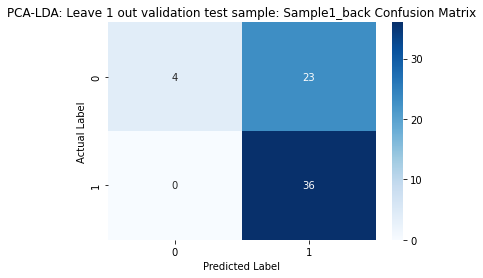

PCA-LDA: Leave 1 out validation test sample: Sample1_front Results:


,Accuracy,Precision,Recall,F1
0,0.75,0.694915,1.0,0.82


Confusion Matrix Shape: (2, 2)
Unique test_y: [0 1]
Unique y_pred: [0 1]


array([[13, 18],
       [ 0, 41]], dtype=int64)

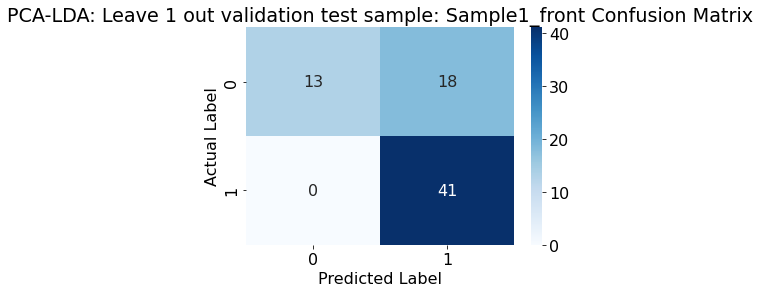

PCA-LDA: Leave 1 out validation test sample: Sample2_back Results:


,Accuracy,Precision,Recall,F1
0,1.0,1.0,1.0,1.0


Confusion Matrix Shape: (1, 1)
Unique test_y: [1]
Unique y_pred: [1]


array([[66]], dtype=int64)

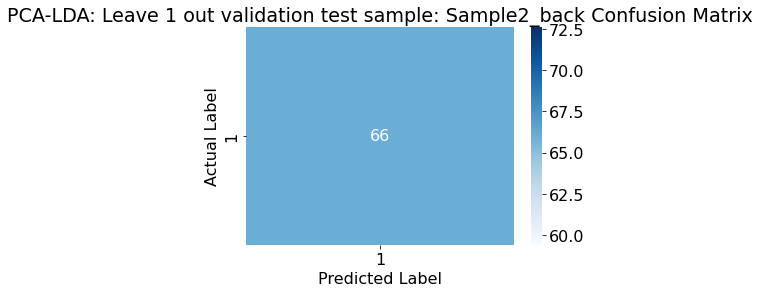

PCA-LDA: Leave 1 out validation test sample: Sample2_front Results:


,Accuracy,Precision,Recall,F1
0,1.0,1.0,1.0,1.0


Confusion Matrix Shape: (1, 1)
Unique test_y: [1]
Unique y_pred: [1]


array([[46]], dtype=int64)

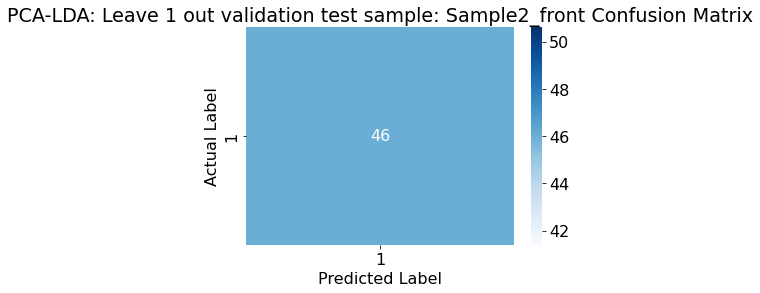

PCA-LDA: Leave 1 out validation test sample: Sample3_back Results:


,Accuracy,Precision,Recall,F1
0,0.962025,0.983871,0.968254,0.976


Confusion Matrix Shape: (2, 2)
Unique test_y: [0 1]
Unique y_pred: [0 1]


array([[15,  1],
       [ 2, 61]], dtype=int64)

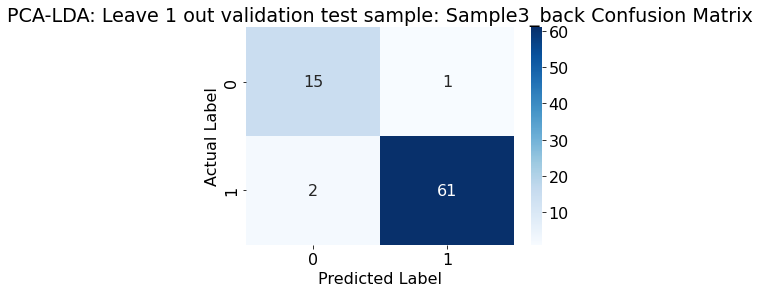

PCA-LDA: Leave 1 out validation test sample: Sample3_front Results:


,Accuracy,Precision,Recall,F1
0,0.835616,1.0,0.809524,0.894737


Confusion Matrix Shape: (2, 2)
Unique test_y: [0 1]
Unique y_pred: [0 1]


array([[10,  0],
       [12, 51]], dtype=int64)

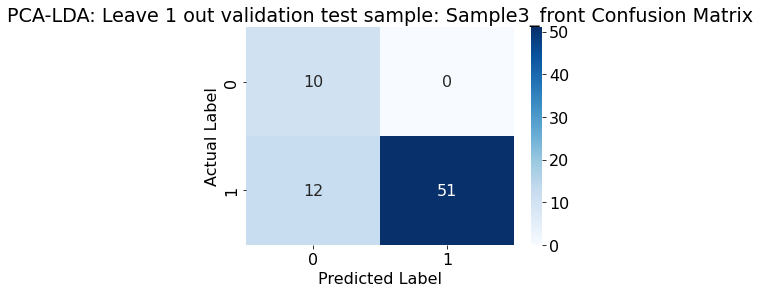

In [43]:
'''Experiment 3.1: k-fold cross validation based on sampleID'''
# Get the unique sample IDs
unique_ids = data_PCALDA_df['SampleID'].unique()
# systematically create a train and test set
for i in range(len(unique_ids)):
    # get the test sample 
    testData_df = data_PCALDA_df[data_PCALDA_df['SampleID'] == unique_ids[i]].reset_index(drop=True)
    # get the train samples
    trainData_df = data_PCALDA_df[data_PCALDA_df['SampleID'] != unique_ids[i]].reset_index(drop=True)
    # fit the model to the train data
    classifier = fit_PCA_LDA(trainData_df=trainData_df, n_components=190)
    # Evaluate the model on the test data
    results_df = evaluate_PCA_LDA(testData_df=testData_df, classifier=classifier, expName=f'PCA-LDA: Leave 1 out validation test sample: {unique_ids[i]}')
    
    # results_df = evaluate_PCA_LDA(testData_df=testData_df, pca_lda_classifier=pca_lda_classifier, expName=f'PCA-LDA: Leave 1 out validation test sample: {unique_ids[i]}')

'''Experiment 3.2: k-fold cross validation based on sample number 1,2,3'''
# Get the unique sample IDs
unique_ids = data_PCALDA_df['Sample Number'].unique()
# systematically create a train and test set
for i in range(len(unique_ids)):
    # get the test sample
    testData_df = data_PCALDA_df[data_PCALDA_df['Sample Number'] == unique_ids[i]].reset_index(drop=True)
    # get the train samples
    trainData_df = data_PCALDA_df[data_PCALDA_df['Sample Number'] != unique_ids[i]].reset_index(drop=True)
    # fit the model to the train data
    classifier = fit_PCA_LDA(trainData_df=trainData_df, n_components=190)
    # Evaluate the model on the test data
    # results_df = evaluate_PCA_LDA(testData_df=testData_df, classifier=classifier, expName=f'PCA-LDA: Leave 1 out validation test sample: {unique_ids[i]}')
                #  evaluate_PCA_LDA(testData_df, classifier, expName='Specify classifier type', average='binary', BY_SAMPLE=False, CM_FLAG=True)

In [44]:
'''Experiment 4: Evaluating the ability of model to predict which sample a reading came from. Train on cancer and test on normal'''



'Experiment 4: Evaluating the ability of model to predict which sample a reading came from. Train on cancer and test on normal'

### Feature reduction experiments

#### PCA - LDA 100 samples

In [45]:
''' def evaluate_classifier 
This function is used to evalute a trained classifier using various metrics
Inputs: testData_df: a dataframe containing the test data
        classifier: a trained classifier
        expName: a string containing the name of the experiment
        average: a string containing the type of averaging to use for the precision and recall metrics
        BY_SAMPLE: a boolean indicating whether to calculate the metrics by sample or not
        CM_FLAG: a boolean indicating whether to plot the confusion matrix or not
Outputs: results_df: a dataframe containing the results of the experiment
'''

# Import balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

def evaluate_classifier(testData_df, classifier, data_column = 'Data_preprocessed',expName='Specify classifier type', average='binary', BY_SAMPLE=False, CM_FLAG=True):
    print(f'{expName} Results:')
    print('Evaluating on data column:',data_column)
    # Extract Test data
    if data_column == 'Data_preprocessed':
        test_X = np.array(testData_df['Data_preprocessed'].tolist())[:, :, 1]
    else:
        test_X = np.array(testData_df[data_column].tolist())
    test_y = np.array(testData_df['Label (numeric)'].tolist())
    print('Shape of the data:',test_X.shape)

    # Evaluate the performance of the classifier on the test data
    y_pred = classifier.predict(test_X)

    # Add the predicted labels to the dataframe
    testData_df['Predicted Label'] = y_pred # I think this is the source of the warning

    # Calculate all of the desired metrics: Accuracy, Precision, Recall, F1
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, average=average)
    recall = recall_score(test_y, y_pred, average=average)
    f1 = f1_score(test_y, y_pred, average=average)
    # Calculate the weighted metrics. This is useful when the classes are imbalanced
    balanced_accuracy = balanced_accuracy_score(test_y, y_pred)


    # display the calculated results in an aesthetic table
    results_df = pd.DataFrame({'Balanced accuracy': [balanced_accuracy], 'Precision' : [precision], 'Recall' : [recall], 'F1' : [f1]}).round({'Value': 2})
    

    if CM_FLAG:
        display(results_df)
        # Display the overall confusion matrix
        cm = confusion_matrix(test_y, y_pred)
        # show shape of cm
        # print('Confusion Matrix Shape:',cm.shape)
        unique_testy = np.unique(test_y)
        unique_predy = np.unique(y_pred)
        # print('Unique test_y:',unique_testy)
        # print('Unique y_pred:',unique_predy)
        classes = np.unique(np.concatenate((unique_testy,unique_predy)))
        # classes = ['normal', 'cancer']
        # classes = [1,2, 3]
        cm_df = pd.DataFrame(cm, index=classes, columns=classes)
        # display(cm)
        displayCM(cm_df, expName=expName)

    if BY_SAMPLE:
        # Display the confusion matrix broken down by sampleID
        cm_dfs, sampleIDs = cmSampleBreakdown(testData_df)
        for i in range(len(cm_dfs)):
            displayCM(cm_dfs[i], expName=f'{expName}: {sampleIDs[i]}')
    return results_df

In [46]:
'''
The process for this experiment is as follows:
1. Train test Split
    - Split the processedData_df into train_df and test_df
2. Feature reduction
    - Perform feature reduction using chosen method on train_df
    - Input: train_df and test_df
    - Output: reduced train_df and test_df (add a column for the reduced data)
4. Classification 
    - Input: train_X, train_y
    - Output: trained classifier
5. Evaluate the classifier
    - Input: trained classifier, test_df
'''
data_df = processedData_df.copy()
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=41)

LDA: Baseline Results:
Evaluating on data column: Data_preprocessed
Shape of the data: (120, 2578)


,Balanced accuracy,Precision,Recall,F1
0,0.894737,0.949495,0.989474,0.969072


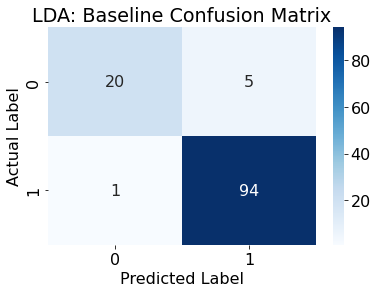

In [47]:
''' Experiment 1: Testing LDA without any feature reduction as baseline '''
def fit_LDA(train_df, data_column):
    # print('Name of data column for LDA: ',data_column)
    # Extract train data
    if data_column == 'Data_preprocessed':
        train_X = np.array(train_df[data_column].tolist())[:, :, 1]
    else:
        train_X = np.array(train_df[data_column].tolist())
    train_y = np.array(train_df['Label (numeric)'].tolist())
    # print('Shape of the data:',train_X.shape)
    # fit the model
    # lda_classifier = LDA(solver='lsqr', shrinkage='auto')
    # lda_classifier = LDA(solver = 'svd')
    lda_classifier = LDA()
    lda_classifier.fit(train_X, train_y)
    return lda_classifier

data_df = processedData_df.copy()
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=41)
# fit the model
lda_classifier = fit_LDA(train_df, data_column = 'Data_preprocessed')
# evaluate the model
results_df = evaluate_classifier(testData_df=test_df, classifier=lda_classifier, expName='LDA: Baseline')

PCA-LDA: 100 components Results:
Evaluating on data column: Data_reduced
Shape of the data: (120, 100)


,Balanced accuracy,Precision,Recall,F1
0,0.934737,0.969072,0.989474,0.979167


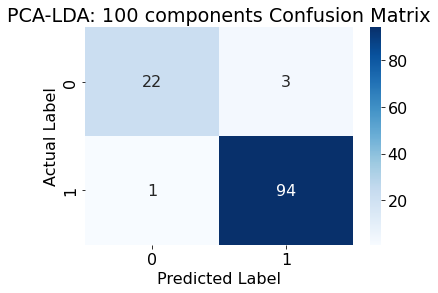

In [48]:
''' Experiment 2: Testing PCA with 100 components '''

data_df = processedData_df.copy()
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=41)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

### Feature reduction
train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
pca = PCA(n_components=100)
pca.fit_transform(train_X)

# Add the reduced data to the train_df
train_X_reduced = pca.transform(train_X)
train_df['Data_reduced'] = [train_X_reduced[i] for i in range(train_X_reduced.shape[0])]
# Add the reduced data to the test_df
test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
test_X_reduced = pca.transform(test_X)
test_df['Data_reduced'] = [test_X_reduced[i] for i in range(test_X_reduced.shape[0])]

### Fitting Classifier
lda = fit_LDA(train_df, data_column='Data_reduced')

### Evaluation
results_df = evaluate_classifier(testData_df=test_df, classifier=lda, data_column = 'Data_reduced', expName='PCA-LDA: 100 components')


Shape of the data: (279, 2578)
Shape of the data after downsampling: (279, 2578)
Binning-LDA: 100 bins Results:
Evaluating on data column: Data_reduced
Shape of the data: (120, 100)


,Balanced accuracy,Precision,Recall,F1
0,0.974737,0.989474,0.989474,0.989474


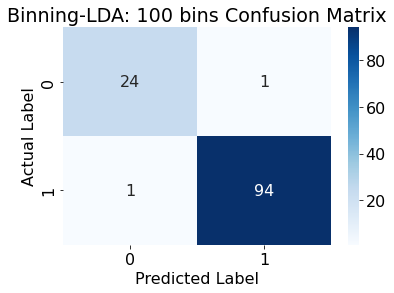

In [49]:
''' Experiment 3: Resampling to 100 wavelengths '''
from scipy import signal
def downsample_data(data, wavelengths, num_points):
    # Compute the number of data points for the desired resolution
    resampled_wavelengths = np.linspace(wavelengths[0], wavelengths[-1], num=num_points)
    # Resample the data to the desired resolution using linear interpolation
    resampled_data = signal.resample(data, num_points)

    return resampled_wavelengths, resampled_data

# Example usage
spectrum = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 1]
wavelengths = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 0]

data_df = processedData_df.copy()
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=41)
# reset the indices
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

### Feature reduction
train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
train_X_wavelengths = np.array(train_df['Data_preprocessed'].tolist())[:, :, 0]
print('Shape of the data:',train_X.shape)
# Downsample the data to 100 points
# loop through the data and downsample each spectrum
num_points = 100
# make an empty array to store the downsampled data
train_X_reduced = np.zeros((train_X.shape[0], num_points))
for i in range(train_X.shape[0]):
    train_X_reduced[i, :] = downsample_data(train_X[i, :], train_X_wavelengths[i, :], num_points=num_points)[1]
print('Shape of the data after downsampling:',train_X.shape)
# Add the reduced data to the train_df
train_df['Data_reduced'] = [train_X_reduced[i] for i in range(train_X_reduced.shape[0])]

### Fitting Classifier
lda = fit_LDA(train_df, data_column='Data_reduced')


### Evaluation
# Downsample the test set
test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
test_X_wavelengths = np.array(test_df['Data_preprocessed'].tolist())[:, :, 0]
num_points = 100
test_X_reduced = np.zeros((test_X.shape[0], num_points))
for i in range(test_X.shape[0]):
    test_X_reduced[i, :] = downsample_data(test_X[i, :], test_X_wavelengths[i, :], num_points=num_points)[1]
# add the reduced data to the test_df
test_df['Data_reduced'] = [test_X_reduced[i] for i in range(test_X_reduced.shape[0])]
results_df = evaluate_classifier(testData_df=test_df, classifier=lda, data_column='Data_reduced',expName='Binning-LDA: 100 bins')


LDA: Feature Selection Results:
Evaluating on data column: Data_reduced
Shape of the data: (120, 100)


,Balanced accuracy,Precision,Recall,F1
0,0.713684,0.873786,0.947368,0.909091


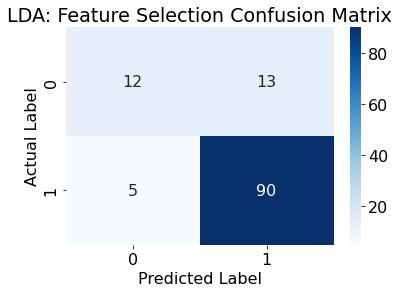

In [50]:
''' Experiment 4: Feature selection techniques using scikitlearn '''
'''
The following code uses the scikitlearn feature selection techniques to select the 100 most impactful features for classification.

1. Start with my full dataset of 279 samples and about 2500 features
2. Fit the lda classifier to the data
3. use lda.feature_importances_ to get the feature importances
4. sort the feature importances and select the top 100 features
5. Determine which wavelengths correspond to the top 100 features
6. Use the top 100 features to train the classifier
7. Reduce the test set to the top 100 features
8. Evaluate the classifier on the test set
'''
# Step 1: Start with the full dataset
data_df = processedData_df.copy()
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=41)

# Step 2: Fit the LDA classifier to the data
lda_classifier = fit_LDA(train_df, data_column='Data_preprocessed')

# Step 3: Extract the most discriminative features
feature_importances = lda_classifier.coef_[0]
# Step 4: Sort the feature importances and select the top 100 features
num_features = 100
# np.argsort(feature_importances) sorts the array feature_importances in ascending order and returns the indices that would sort the array.
top_indices = np.argsort(feature_importances)[::-1][:num_features]

# show an example of the features
selected_wavelengths = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 0][top_indices]
selected_features = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 1][top_indices]

fig = go.Figure(data=go.Scatter(x=selected_wavelengths, y=selected_features, mode='markers'))
fig.update_layout(
    xaxis=dict(title='Wavelength (nm)'),
    yaxis=dict(title='Intensity (a.u.)'),
    title=f'Top {num_features} Selected Wavelengths',
    width=figSize[0],
    height=figSize[1]
)
fig.show()

# Step 5: Reduce the train and test data to the selected features
train_X_top = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1][:, top_indices]
test_X_top = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1][:, top_indices]

# Step 5.1 Add the reduced data to the train_df
train_df['Data_reduced'] = [train_X_top[i] for i in range(train_X_top.shape[0])]
# Step 5.2 Add the reduced data to the test_df
test_df['Data_reduced'] = [test_X_top[i] for i in range(test_X_top.shape[0])]

# Step 6: Fit the classifier to the reduced data
lda_classifier = fit_LDA(train_df,data_column='Data_reduced')

# Step 7: Evaluate the classifier on the test set
results_df = evaluate_classifier(testData_df=test_df, classifier=lda_classifier, data_column='Data_reduced', expName='LDA: Feature Selection')



# Ablation study - thesis results generation

### Imports


In [51]:
# Import all of the requried libraries
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
# import statistics
from statistics import mode,mean
from scipy import interpolate
import os
import os.path
import json
import time

from scipy import signal
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# These are all of the libraries that I manually created

import IOfunctions as IO
import GUIfunctions as GUI
import Processfunctions as process


# Through 3D slicer
# start_index = 0 # starts at 195nm
# start_index = 742 # starts at 350nm
start_index = 790 # starts at 360nm
# start_index = 1070 # starts at 420nm

# print pandas version
print(pd.__version__)

2.0.0


In [52]:
def loadSpectrum(path, col_name=None,start_index=774,end_index=-1,sep=';'):
#     df = pd.read_csv(path + name,sep=';',engine='python')
    df = pd.read_csv(path,sep=sep,engine='python')
#     print(df)
    if not(col_name == None):
        df[col_name] = df.index
    data = df[start_index:end_index]
#     print(data)
    data_arr = data.to_numpy()
    data_arr = np.array(data_arr,dtype='float')
    return data_arr

In [53]:
''' Data loader '''
# Load in the dataset from file
dataset_name = 'KidneyData_march3'
trialPath = "C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03"
# Load in the dataset from file 
file_name = os.path.join(trialPath, dataset_name + '_Formatted_Dataset.csv')
# Load in the dataset
Dataset_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
Dataset_df['Data'] = Dataset_df['Data'].apply(lambda x: np.array(json.loads(x)))
# print the details of the Dataset_df
print('Dataset_df shape: ', Dataset_df.shape)
display(Dataset_df.head())


# Load in the ambient light baselines dataframe
file_name = os.path.join(trialPath, 'ambient_baseline_and_ratios.csv')
baseline_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
baseline_df['Baseline Ambient Light'] = baseline_df['Baseline Ambient Light'].apply(lambda x: np.array(json.loads(x)))
baseline_df.shape
baseline_df.head()
ambient_baseline_df = baseline_df.copy()
# display the ambient_baseline_df
display(ambient_baseline_df.head())


# Load in the characteristic light source output
dataPath = "C:\GithubProjects\Spectroscopy_TrackedTissueSensing\data\March2022_raw_data\SLS201L_Spectrum_reformatted.csv"
print(dataPath)
lightsource_output_curve = loadSpectrum(dataPath, 'Wavelength', start_index=10, end_index=675, sep=',')
print(lightsource_output_curve[:,0:2].shape)
# Interpolate such that the downloaded spectrum has the same values of the data
x = lightsource_output_curve[:,0]
y = lightsource_output_curve[:,1]
f = interpolate.interp1d(x,y)
xnew = Dataset_df['Data'][1][:,0]
ynew = f(xnew)
lightsource_output_curve = np.transpose(np.array([xnew,ynew]))
print(lightsource_output_curve.shape)

# # Plot an example of the data
# plt.figure(figsize=(10, 5))
# plt.plot(Dataset_df['Data'][1][:,0], Dataset_df['Data'][1][:,1])
# plt.title('Example of the data')
# plt.xlabel('Time (s)')



Dataset_df shape:  (399, 6)


,PatientID,SampleID,Label (numeric),Label,Data,Time
0,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0055262738350994245], ...",1.677865e+09
1,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0021762760675127974], ...",1.677866e+09
2,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.004287867652463011], [...",1.677866e+09
3,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.003312623581628423], [...",1.677866e+09
4,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.008101678916785034], [...",1.677866e+09


,SampleID,Label (numeric),Baseline Ambient Light,Baseline Ratio
0,Sample1_back,1,"[[360.14014912872346, -0.0001484845964835164],...",0.980610
1,Sample1_back,0,"[[360.14014912872346, 0.00021889438755883715],...",1.040830
2,Sample1_front,1,"[[360.14014912872346, 0.00035107249884581434],...",1.085760
3,Sample1_front,0,"[[360.14014912872346, -3.652628082945304e-05],...",0.978271
4,Sample2_back,1,"[[360.1401491287235, 0.00020839429144461395], ...",1.071722


C:\GithubProjects\Spectroscopy_TrackedTissueSensing\data\March2022_raw_data\SLS201L_Spectrum_reformatted.csv
(665, 2)
(2858, 2)


In [54]:
def preprocessing_pipeline(Dataset_df,ambient_baseline_df, lightsource_output_curve,FLAG_AMBIENT_LIGHT,FLAG_CROP, FLAG_NORMALIZE, FLAG_TFUNC):
    
    print('Preprocessing Flags:')
    print('FLAG_AMBIENT_LIGHT:',FLAG_AMBIENT_LIGHT)
    print('FLAG_CROP:',FLAG_CROP)
    print('FLAG_NORMALIZE:',FLAG_NORMALIZE)
    print('FLAG_TFUNC:',FLAG_TFUNC)
    
    # Step 1: Remove ambient light peak method 1 or 2
    if FLAG_AMBIENT_LIGHT:
        if FLAG_AMBIENT_LIGHT == 1:
            # print(FLAG_AMBIENT_LIGHT)
            data = np.array(Dataset_df['Data'].tolist())
            data = removeAmbientLight_method1(data) # Method 1: Remove just the peak of the ambient light
        if FLAG_AMBIENT_LIGHT == 2:
            # print(FLAG_AMBIENT_LIGHT)
            data = removeAmbientLight_method2(Dataset_df,ambient_baseline_df) # Method 2: Estimate the ambient light for each scan
    else:
        data = np.array(Dataset_df['Data'].tolist())

    # Step 2: Crop the data to 420 nm
    if FLAG_CROP:
        data = data[:,280:,:]
        lightsource_output_curve = lightsource_output_curve[280:,:]
    # print('Data shape after cropping:',lightsource_output_curve[:,1])

    # Step 3: Normalize the data using minimax
    if FLAG_NORMALIZE: 
        data = process.normalize(data)

    # Step 4: Divide by the baseline transfer function
    if FLAG_TFUNC:
        data = divTfuc(data,lightsource_output_curve[:,1])

    # Step 5: Feature reduction

    processed_data = data.copy()

    # Step 6: Turn the processed data into a singe data column in a dataframe
    data_df = pd.DataFrame()
    for i in range(processed_data.shape[0]):
        new_row = {'Data_preprocessed':processed_data[i,:,:]}
        data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)
    # Add the data to the dataframe
    processedData_df = pd.concat([Dataset_df, data_df], axis=1)
    return processedData_df

In [55]:
def removeAmbientLight_method1(data):
    start_index = 1110
    width = 20
    end_index = start_index + width
    for i in range(len(data)):
        data[i,start_index:end_index,1] = 0
    return data

In [56]:
def removeAmbientLight_method2(Dataset_df, baseline_df):
    Dataset = []
    for i in range(Dataset_df.shape[0]):
        # Get the data
        data = np.array(Dataset_df['Data'].tolist())[i,:,:]
        # Get the sampleID
        sampleID = Dataset_df['SampleID'][i]
        # Get the label
        label = Dataset_df['Label (numeric)'][i]
        # print(label)
        # Find the corresponding baseline ambient light and the baseline ratio
        # Get the row of baseline_df where baseline_df['sampleID'] == sampleID and 
        baseline_sample_row = baseline_df.loc[(baseline_df['SampleID'] == sampleID)]
        # Get the row of baseline_df where baseline_df['Label (numeric)'] == Label (numeric)
        # print(baseline_sample_row['Label (numeric)']=='1')
        # print (baseline_sample_row['Label (numeric)'][0])
        # print (str(label))
        # display(baseline_sample_row)
        baseline_row = baseline_sample_row.loc[(baseline_sample_row['Label (numeric)'] == label)]
        # display(baseline_row)
        # print(baseline_row)
        # if baseline_row is empty give an error
        if baseline_row.empty:
            print("Error: baseline_row is empty")
            break
        
        # Get the baseline ambient light
        ambient_baseline = np.array(baseline_row['Baseline Ambient Light'].tolist())[0,:,:]
        # Get the baseline ratio
        ratio_baseline = np.array(baseline_row['Baseline Ratio'].tolist())[0]

        # Remove ambient light peak
        data = removeAmbientLight1(data,ambient_baseline,ratio_baseline)

        Dataset.append(data)

        # Normalize the data
        # data = process.normalize(data)
        # Display the data
        # GUI.plotSpectra(xdata=data[:,0],ydata=data[:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity', title='Signal Spectrum after subtracting ambient light')
    # Return the dataset as an array
    Dataset = np.array(Dataset,dtype='float')
    return Dataset

In [57]:
def divTfuc(inputData,tFunc):    
    outputData = inputData.copy()
    # For each spectra
    for i in range (inputData[:,:,1].shape[0]):
        data = inputData[i,:,1]
        # Divide by the baseline transfer function
        outputData[i,:,1] = data / tFunc 
    outputData = process.normalize(outputData)
    return outputData



In [58]:
def fit_LDA(train_df, data_column):
    # print('Name of data column for LDA: ',data_column)
    # Extract train data
    if data_column == 'Data_preprocessed':
        train_X = np.array(train_df[data_column].tolist())[:, :, 1]
    else:
        train_X = np.array(train_df[data_column].tolist())
    train_y = np.array(train_df['Label (numeric)'].tolist())
    # print('Shape of the data:',train_X.shape)
    # fit the model
    # lda_classifier = LDA(solver='lsqr', shrinkage='auto')
    # lda_classifier = LDA(solver = 'svd')
    lda_classifier = LDA()
    lda_classifier.fit(train_X, train_y)
    return lda_classifier

Dataset_df shape:  (399, 6)
Preprocessing Flags:
FLAG_AMBIENT_LIGHT: 1
FLAG_CROP: True
FLAG_NORMALIZE: True
FLAG_TFUNC: True


Dataset_df shape:  (399, 8)


,PatientID,SampleID,Label (numeric),Label,Data,Time,Data_preprocessed,Sample Number
0,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0055262738350994245], ...",1.677865e+09,"[[420.90898285766394, 0.3597617805746842], [42...",1
1,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0021762760675127974], ...",1.677866e+09,"[[420.90898285766394, 0.358197989908818], [421...",1
2,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.004287867652463011], [...",1.677866e+09,"[[420.90898285766394, 0.3501802805867988], [42...",1
3,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.003312623581628423], [...",1.677866e+09,"[[420.90898285766394, 0.33684240049988806], [4...",1
4,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.008101678916785034], [...",1.677866e+09,"[[420.90898285766394, 0.384167552594301], [421...",1


Text(0.5, 0, 'Time (s)')

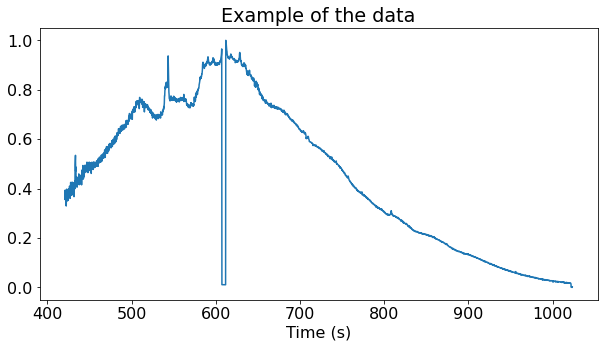

In [59]:
''' Preprocessing Pipeline 
'''
# Preprocessing flags
FLAG_NORMALIZE = True       # True, False
FLAG_AMBIENT_LIGHT = 1   # None, 1, 2
FLAG_CROP = True           # True, False
FLAG_TFUNC = True          # True, False

# print the shape of the dataset
print('Dataset_df shape: ', Dataset_df.shape)
processedData_df = preprocessing_pipeline(Dataset_df,ambient_baseline_df, lightsource_output_curve,FLAG_AMBIENT_LIGHT,FLAG_CROP, FLAG_NORMALIZE, FLAG_TFUNC)

data_df = processedData_df.copy()
# Add the sample number to the dataframe
data_df['Sample Number'] = data_df['SampleID'].str.extract('(\d+)').astype(int)

# print the details of the Dataset_df
print('Dataset_df shape: ', data_df.shape)
display(data_df.head())

# Plot an example of the data
plt.figure(figsize=(10, 5))
plt.plot(data_df['Data_preprocessed'][1][:,0], data_df['Data_preprocessed'][1][:,1])
plt.title('Example of the data')
plt.xlabel('Time (s)')

### Model Trainer

In [60]:
def downsample_data(data, wavelengths, num_points):
    data = data.copy()
    # Compute the number of data points for the desired resolution
    resampled_wavelengths = np.linspace(wavelengths[0], wavelengths[-1], num=num_points)
    # Resample the data to the desired resolution using linear interpolation
    resampled_data = signal.resample(data, num_points)

    return resampled_wavelengths, resampled_data

In [61]:
''' def evaluate_classifier 
This function is used to evalute a trained classifier using various metrics
Inputs: testData_df: a dataframe containing the test data
        classifier: a trained classifier
        expName: a string containing the name of the experiment
        average: a string containing the type of averaging to use for the precision and recall metrics
        BY_SAMPLE: a boolean indicating whether to calculate the metrics by sample or not
        CM_FLAG: a boolean indicating whether to plot the confusion matrix or not
Outputs: results_df: a dataframe containing the results of the experiment
'''

# Import balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

def evaluate_classifier(testData_df, classifier, data_column = 'Data_preprocessed',expName='Specify classifier type', average='binary', BY_SAMPLE=False, CM_FLAG=True):
    # print(f'{expName} Results:')
    # print('Evaluating on data column:',data_column)
    # Extract Test data
    if data_column == 'Data_preprocessed':
        test_X = np.array(testData_df['Data_preprocessed'].tolist())[:, :, 1]
    else:
        test_X = np.array(testData_df[data_column].tolist())
    test_y = np.array(testData_df['Label (numeric)'].tolist())
    # print('Shape of the data:',test_X.shape)

    # Evaluate the performance of the classifier on the test data
    y_pred = classifier.predict(test_X)

    # Add the predicted labels to the dataframe
    testData_df['Predicted Label'] = y_pred # I think this is the source of the warning
    # Print the unique predicted labels
    # print('Unique predicted labels:',np.unique(y_pred))


    # Calculate all of the desired metrics: Accuracy, Precision, Recall, F1
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, average=average)
    recall = recall_score(test_y, y_pred, average=average)
    f1 = f1_score(test_y, y_pred, average=average)
    # Calculate the weighted metrics. This is useful when the classes are imbalanced
    balanced_accuracy = balanced_accuracy_score(test_y, y_pred)


    # display the calculated results in an aesthetic table
    results_df = pd.DataFrame({'Balanced accuracy': [balanced_accuracy], 'Precision' : [precision], 'Recall' : [recall], 'F1' : [f1]}).round({'Value': 2})
    

    if CM_FLAG:
        # display(results_df)
        # Display the overall confusion matrix
        cm = confusion_matrix(test_y, y_pred)
        # show shape of cm
        # print('Confusion Matrix Shape:',cm.shape)
        unique_testy = np.unique(test_y)
        unique_predy = np.unique(y_pred)
        # print('Unique test_y:',unique_testy)
        # print('Unique y_pred:',unique_predy)
        classes = np.unique(np.concatenate((unique_testy,unique_predy)))
        # classes = ['normal', 'cancer']
        # classes = [1,2, 3]
        cm_df = pd.DataFrame(cm, index=classes, columns=classes)
        # display(cm)
        displayCM(cm_df, expName=expName)

    if BY_SAMPLE:
        # Display the confusion matrix broken down by sampleID
        cm_dfs, sampleIDs = cmSampleBreakdown(testData_df)
        for i in range(len(cm_dfs)):
            displayCM(cm_dfs[i], expName=f'{expName}: {sampleIDs[i]}')
    return results_df

def displayCM(cm_df, expName='PCA-LDA'):
    print(cm_df)
    plt.figure()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g', cbar=False)
    # create another sns.heatmate without a colourbar

    # plt.title(f'{expName} Confusion Matrix')
    # update the size of the text
    plt.rcParams.update({'font.size': 25})
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    # Remove the colour bar from the side of the colour bar
    plt.show()

# # create a cm_df
# # cm_df = pd.DataFrame([[24,1],[39,87]], index=['0','1'], columns=['0','1'])
# cm_df = pd.DataFrame([[0,0],[0,112]], index=['0','1'], columns=['0','1'])
# print(cm_df)
# displayCM(cm_df, expName='Test')

In [62]:
''' FEATURE REDUCTION '''

def feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD,reduced_points=100, CM_FLAG = True):
    # Print the shape of the train and test data
    # print('Shape of the train data:', train_df.shape)
    # print('Shape of the test data:', test_df.shape)


    # CM_FLAG = True
    # print('Feature Reduction Method:',FLAG_FEATURE_REDUCTION_METHOD)
    if FLAG_FEATURE_REDUCTION_METHOD == 'None':
        train_df['Data_reduced'] = train_df['Data_preprocessed']
        test_df['Data_reduced'] = test_df['Data_preprocessed']
        # fit the model
        lda_classifier = fit_LDA(train_df, data_column = 'Data_preprocessed')
        # evaluate the model
        results_df = evaluate_classifier(testData_df=test_df, classifier=lda_classifier, expName='LDA: Baseline',CM_FLAG=CM_FLAG)
    elif FLAG_FEATURE_REDUCTION_METHOD == 'PCA':
        train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
        pca = PCA(n_components=reduced_points)
        pca.fit_transform(train_X)
        # Add the reduced data to the train_df
        train_X_reduced = pca.transform(train_X)
        train_df['Data_reduced'] = [train_X_reduced[i] for i in range(train_X_reduced.shape[0])]
        # Add the reduced data to the test_df
        test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
        test_X_reduced = pca.transform(test_X)
        test_df['Data_reduced'] = [test_X_reduced[i] for i in range(test_X_reduced.shape[0])]
        ### Fitting Classifier
        lda = fit_LDA(train_df, data_column='Data_reduced')
        ### Evaluation
        results_df = evaluate_classifier(testData_df=test_df, classifier=lda, data_column = 'Data_reduced', expName='PCA-LDA: 100 components',CM_FLAG=CM_FLAG) 
    elif FLAG_FEATURE_REDUCTION_METHOD == 'Binning':
        train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
        test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
        # Get the wavelengths for each spectrum
        train_X_wavelengths = np.array(train_df['Data_preprocessed'].tolist())[:, :, 0]
        test_X_wavelengths = np.array(test_df['Data_preprocessed'].tolist())[:, :, 0]

        # Downsample the data to reduced_points points
        # loop through the data and downsample each spectrum
        num_points = reduced_points
        # make an empty array to store the downsampled data
        train_X_reduced = np.zeros((train_X.shape[0], num_points))
        # print('Shape of the train data before downsampling:', train_X.shape[0])
        for i in range(train_X.shape[0]):
            train_X_reduced[i, :] = downsample_data(train_X[i, :], train_X_wavelengths[i, :], num_points=num_points)[1]
        # print('Shape of the data after downsampling:',train_X.shape)
        # Add the reduced data to the train_df
        train_df['Data_reduced'] = [train_X_reduced[i] for i in range(train_X_reduced.shape[0])]
        ### Fitting Classifier
        lda = fit_LDA(train_df, data_column='Data_reduced')
        ### Evaluation
        # Downsample the test set
        
        test_X_wavelengths = np.array(test_df['Data_preprocessed'].tolist())[:, :, 0]
        test_X_reduced = np.zeros((test_X.shape[0], num_points))
        # print('Shape of the test data before downsampling:', test_X.shape)
        for i in range(test_X.shape[0]):
            test_X_reduced[i, :] = downsample_data(test_X[i, :], test_X_wavelengths[i, :], num_points=num_points)[1]
        # add the reduced data to the test_df
        test_df['Data_reduced'] = [test_X_reduced[i] for i in range(test_X_reduced.shape[0])]
        results_df = evaluate_classifier(testData_df=test_df, classifier=lda, data_column='Data_reduced',expName='Binning-LDA: 100 bins',CM_FLAG=CM_FLAG)
    elif FLAG_FEATURE_REDUCTION_METHOD == 'Feature_Selection':
        # Step 1: Get the train and test data
        train_X = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1]
        test_X = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1]
        # Step 2: Fit the LDA classifier to the data
        lda_classifier = fit_LDA(train_df, data_column='Data_preprocessed')
        
        # Step 3: Extract the most discriminative features
        feature_importances = lda_classifier.coef_[0]
        # Step 4: Sort the feature importances and select the top reduced_points features
        num_features = reduced_points
        # np.argsort(feature_importances) sorts the array feature_importances in ascending order and returns the indices that would sort the array.
        top_indices = np.argsort(feature_importances)[::-1][:num_features]
        # top_indices = np.argsort(abs(feature_importances))[::-1][:num_features] % Makes it worse


        # show an example of the features
        selected_wavelengths = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 0][top_indices]
        selected_features = np.array(processedData_df['Data_preprocessed'].tolist())[0, :, 1][top_indices]

        # fig = go.Figure(data=go.Scatter(x=selected_wavelengths, y=selected_features, mode='markers'))
        # fig.update_layout(
        #     xaxis=dict(title='Wavelength (nm)'),
        #     yaxis=dict(title='Intensity (a.u.)'),
        #     title=f'Top {num_features} Selected Wavelengths',
        #     width=figSize[0],
        #     height=figSize[1]
        # )
        # fig.show()

        # Step 5: Reduce the train and test data to the selected features
        train_X_top = np.array(train_df['Data_preprocessed'].tolist())[:, :, 1][:, top_indices]
        test_X_top = np.array(test_df['Data_preprocessed'].tolist())[:, :, 1][:, top_indices]

        # Step 5.1 Add the reduced data to the train_df
        train_df['Data_reduced'] = [train_X_top[i] for i in range(train_X_top.shape[0])]
        # Step 5.2 Add the reduced data to the test_df
        test_df['Data_reduced'] = [test_X_top[i] for i in range(test_X_top.shape[0])]

        # Step 6: Fit the classifier to the reduced data
        lda_classifier = fit_LDA(train_df,data_column='Data_reduced')

        # Step 7: Evaluate the classifier on the test set
        results_df = evaluate_classifier(testData_df=test_df, classifier=lda_classifier, data_column='Data_reduced', expName='LDA: Feature Selection',CM_FLAG=CM_FLAG)
    return results_df

# # feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD)

In [63]:
''' TRAIN TEST SPLIT '''

TRAIN_TEST_SPLIT_METHOD = 'sampleID' # random, sampleID, sample
FLAG_FEATURE_REDUCTION_METHOD = 'Feature_Selection' # None, PCA, Binning, Feature_Selection
reduced_points = 100

# print all the flags used
print('Preprocessing Flags:')
print('FLAG_AMBIENT_LIGHT:',FLAG_AMBIENT_LIGHT)
print('FLAG_CROP:',FLAG_CROP)
print('FLAG_NORMALIZE:',FLAG_NORMALIZE)
print('FLAG_TFUNC:',FLAG_TFUNC)
print('TRAIN_TEST_SPLIT_METHOD:',TRAIN_TEST_SPLIT_METHOD)
print('FLAG_FEATURE_REDUCTION_METHOD:',FLAG_FEATURE_REDUCTION_METHOD)

# run i times to find average and std
balanced_accuracys = []
F1s = []
for i in range(1):
# for i in range(1,51):    
    if TRAIN_TEST_SPLIT_METHOD == 'random':
        # for random_state in range(1,6):
            # zebra = random_state
            # print('Random State:',zebra)
            train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=i)

            train_df.reset_index(drop=True, inplace=True)
            test_df.reset_index(drop=True, inplace=True)
            # Feature reduction and classification
            results_df = feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD,reduced_points,CM_FLAG = False)
    elif TRAIN_TEST_SPLIT_METHOD == 'sample':
        # Get the unique Sample Numbers
        unique_ids = data_df['Sample Number'].unique()
        # print('Unique Sample Numbers:',unique_ids)
        # Perform a train test split based on sample number
        result_all = []
        for i in range(len(unique_ids)):
            print("Test set is sample number:",unique_ids[i])
            # get the train samples
            train_df = data_df[data_df['Sample Number'] != unique_ids[i]].reset_index(drop=True)
            # get the test sample
            test_df = data_df[data_df['Sample Number'] == unique_ids[i]].reset_index(drop=True)
            results_df = feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD, reduced_points,CM_FLAG=False)
            result_all.append(results_df)
        # concatenate all of the results
        results_df = pd.concat(result_all).reset_index(drop=True)
        display(results_df)
        # Get the average and standard deviation of each column
        results_df_mean = results_df.mean(axis=0).to_frame().T
        results_df_mean['Metric'] = 'Mean'  
        results_df_std = results_df.std(axis=0).to_frame().T
        results_df_std['Metric'] = 'Std'
        results_df = pd.concat([results_df_mean,results_df_std]).reset_index(drop=True)
        display(results_df)
    elif TRAIN_TEST_SPLIT_METHOD == 'sampleID':
        # Get the unique sample IDs
        unique_ids = data_df['SampleID'].unique()
        # Perform a train test split based on sampleID
        result_all = []
        for i in range(len(unique_ids)):
            # get the test sample 
            test_df = data_df[data_df['SampleID'] == unique_ids[i]].reset_index(drop=True)
            # get the train samples
            train_df = data_df[data_df['SampleID'] != unique_ids[i]].reset_index(drop=True)
            results_df = feature_reduction(train_df,test_df,FLAG_FEATURE_REDUCTION_METHOD, reduced_points, CM_FLAG=False)
            result_all.append(results_df)
        # concatenate all of the results
        results_df = pd.concat(result_all).reset_index(drop=True)
        display(results_df)
        # Get the average and standard deviation of each column
        results_df_mean = results_df.mean(axis=0).to_frame().T
        results_df_mean['Metric'] = 'Mean'  
        results_df_std = results_df.std(axis=0).to_frame().T
        results_df_std['Metric'] = 'Std'
        results_df = pd.concat([results_df_mean,results_df_std]).reset_index(drop=True)
        display(results_df)
    # extract the balanced accuracy
    # list the column names of the results_df
    # print('Column names:',results_df.columns)
    balanced_accuracy = results_df['Balanced accuracy'][0]
    balanced_accuracys.append(balanced_accuracy)
    F1 = results_df['F1'][0]
    F1s.append(F1)
# RESULTS
print('Average Balanced Accuracy:',np.mean(balanced_accuracys))
print('Standard Deviation:',np.std(balanced_accuracys))

print('Average F1:',np.mean(F1s))
print('Standard Deviation:',np.std(F1s))

# # Plot the balanced accuracy 
# fig = go.Figure(data=go.Scatter(x=np.arange(len(balanced_accuracys)), y=balanced_accuracys, mode='markers'))
# fig.update_layout(
#     xaxis=dict(title='Iteration'),
#     yaxis=dict(title='Balanced Accuracy'),
#     title=f'Balanced Accuracy for {TRAIN_TEST_SPLIT_METHOD} train test split',
#     width=figSize[0],
#     height=figSize[1]
# )
# fig.show()



Preprocessing Flags:
FLAG_AMBIENT_LIGHT: 1
FLAG_CROP: True
FLAG_NORMALIZE: True
FLAG_TFUNC: True
TRAIN_TEST_SPLIT_METHOD: sampleID
FLAG_FEATURE_REDUCTION_METHOD: Feature_Selection


,Balanced accuracy,Precision,Recall,F1
0,0.518519,0.580645,1.000000,0.734694
1,0.596774,0.621212,1.000000,0.766355
2,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000
4,0.913194,0.982456,0.888889,0.933333
5,0.543651,0.880952,0.587302,0.704762


,Balanced accuracy,Precision,Recall,F1,Metric
0,0.762023,0.844211,0.912698,0.856524,Mean
1,0.232554,0.194009,0.165491,0.136437,Std


Average Balanced Accuracy: 0.7620229916936906
Standard Deviation: 0.0
Average F1: 0.8565240426388625
Standard Deviation: 0.0
